In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

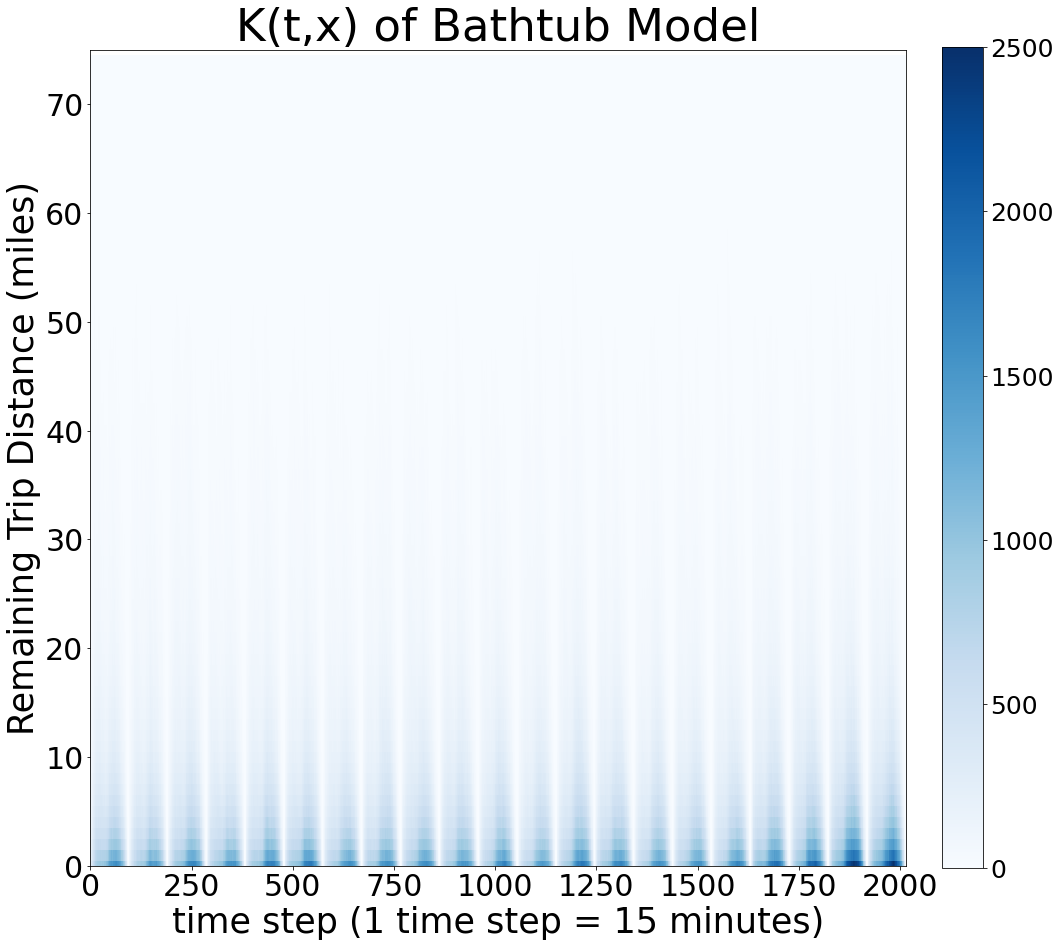

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.011837850017502941 0.011837850017502941 0.8362711986991572
0.010645451494475754 0.010645451494475754 0.7923803158274041
0.0098265070604803984 0.0098265070604803984 0.7589127720531429
0.00975478498861164 0.00975478498861164 0.7559703456960385
0.00966424500021722 0.00966424500021722 0.7524211740649923
0.009600945813540122 0.009600945813540122 0.7499031024499354
0.0093305518370795232 0.0093305518370795232 0.7393504685024805
0.00903194556808979 0.00903194556808979 0.7277467174076888
0.0087800629835372655 0.0087800629835372655 0.7178640929204764
0.00834175588388447 0.00834175588388447 0.7004301487329428
0.0080452460995745715 0.0080452460995745715 0.6896313201528335
0.0078940573910093736 0.0078940573910093736 0.6824064222769409
0.0078490200452170575 0.0078490200452170575 0.6807083814936689
0.0078230827262105868 0.0078230827262105868 0.6794571995807175
0.0077109283514518352 0.0077109283514518352 0.674043301803404
0.0076361290886580281 0.0076361290886580281 0.6706366154663903
0.0074812314269

0.0030092328784596598 0.0030092328784596598 0.4306841750463327
0.0030089207111949354 0.0030089207111949354 0.43065103237321245
0.0030087149802378427 0.0030087149802378427 0.4305518087036487
0.0030086282988492185 0.0030086282988492185 0.4305788434051932
0.0030085155514647673 0.0030085155514647673 0.43055556158268987
0.0030081301383667433 0.0030081301383667433 0.4304893934644295
0.0030077343276493844 0.0030077343276493844 0.4304551934758935
0.0030066274841138558 0.0030066274841138558 0.43040659728414143
0.0030052424555175685 0.0030052424555175685 0.4304111840415899
0.0030033169502676244 0.0030033169502676244 0.43055463676668093
0.0030021274010036646 0.0030021274010036646 0.4305247537168512
0.0030014410243281008 0.0030014410243281008 0.43052217151741373
0.003000988994161154 0.003000988994161154 0.43040839140137077
0.0030002761288781452 0.0030002761288781452 0.4304061591798423
0.0029992291137331019 0.0029992291137331019 0.43042386186542164
0.0029972726317088723 0.0029972726317088723 0.4303

0.0029789644140177213 0.0029789644140177213 0.4292871125181066
0.0029789441314229453 0.0029789441314229453 0.42929247136774606
0.0029789176615805418 0.0029789176615805418 0.42930889432200253
0.0029789015788232328 0.0029789015788232328 0.42931851591673365
0.002978893346745537 0.002978893346745537 0.42931209521877267
0.00297888974616413 0.00297888974616413 0.42930990179105055
0.0029788878742159626 0.0029788878742159626 0.42930914132356884
0.0029788871513154788 0.0029788871513154788 0.42931462874232607
0.00297888670762146 0.00297888670762146 0.42931600400639547
0.0029788860112396312 0.0029788860112396312 0.42931751207958
0.0029788833133496582 0.0029788833133496582 0.42932061026047597
0.0029788769154914293 0.0029788769154914293 0.42932418601491157
0.0029788596501089115 0.0029788596501089115 0.4293279363249931
0.0029788079664914676 0.0029788079664914676 0.42933283600309624
0.0029787530975859513 0.0029787530975859513 0.42934094127802425
0.0029787193922684251 0.0029787193922684251 0.429326073

0.0029729077535807875 0.0029729077535807875 0.4287038312923944
0.0029728766430551054 0.0029728766430551054 0.42868250119652074
0.0029728500799971473 0.0029728500799971473 0.4286796687856949
0.0029728322987224104 0.0029728322987224104 0.4286864926137947
0.002972816771806911 0.002972816771806911 0.4286872791763427
0.0029727963825214973 0.0029727963825214973 0.4286924437941337
0.0029727774653747737 0.0029727774653747737 0.42870146124392905
0.0029727634077247596 0.0029727634077247596 0.42868707375761517
0.0029727349223004533 0.0029727349223004533 0.42868678284112816
0.0029727050336401783 0.0029727050336401783 0.42868553307399615
0.0029726459314980695 0.0029726459314980695 0.42867653952068285
0.0029725678915264913 0.0029725678915264913 0.42864847536964884
0.0029725527450657646 0.0029725527450657646 0.4286634146577514
0.0029725185798254788 0.0029725185798254788 0.42866722421168735
0.0029724801510915013 0.0029724801510915013 0.4286139464925413
0.0029724474797902171 0.0029724474797902171 0.428

0.0029714783803098184 0.0029714783803098184 0.42870082314425456
0.0029714712912693761 0.0029714712912693761 0.428702306483267
0.00297145231070769 0.00297145231070769 0.4287000502058795
0.0029714080457759746 0.0029714080457759746 0.42867561106588264
0.0029713771530632854 0.0029713771530632854 0.42864291328438375
0.002971362654973558 0.002971362654973558 0.42862303334929025
0.002971343528660123 0.002971343528660123 0.42862024139145144
0.0029713277011719236 0.0029713277011719236 0.42862347676234736
0.0029712999589206063 0.0029712999589206063 0.4286292358767393
0.0029712769779380453 0.0029712769779380453 0.428622867854933
0.0029712501083844129 0.0029712501083844129 0.42863296491878844
0.0029712345802832257 0.0029712345802832257 0.428635461050482
0.0029711986142741884 0.0029711986142741884 0.42862277804076837
0.0029711695708046653 0.0029711695708046653 0.4286233977902115
0.0029711631841251225 0.0029711631841251225 0.42858828420293993
0.0029711381517157497 0.0029711381517157497 0.42859478545

0.0029696804234658172 0.0029696804234658172 0.42860287884271764
0.0029696717959719434 0.0029696717959719434 0.4285955823401406
0.0029696681547899842 0.0029696681547899842 0.428613986991455
0.0029696650771506663 0.0029696650771506663 0.42859767878558686
0.0029696620051353393 0.0029696620051353393 0.4286034934974923
0.00296965798514047 0.00296965798514047 0.428605169988866
0.0029696534302274496 0.0029696534302274496 0.42860964027416254
0.002969645544247921 0.002969645544247921 0.4286125989943161
0.0029696352290083804 0.0029696352290083804 0.42862655443749254
0.0029696260406631612 0.0029696260406631612 0.4286074807873079
0.0029696177434311495 0.0029696177434311495 0.42862185780322026
0.0029696128080365022 0.0029696128080365022 0.42863921727398613
0.0029696048815710677 0.0029696048815710677 0.42862421683972274
0.002969599843271175 0.002969599843271175 0.4286353391532807
0.00296959273204785 0.00296959273204785 0.42863057283330536
0.0029695869897177246 0.0029695869897177246 0.428638589559998

0.0029691030422908534 0.0029691030422908534 0.428783890062813
0.0029691026256606335 0.0029691026256606335 0.42878440975345417
0.0029691022358066042 0.0029691022358066042 0.4287871144704418
0.0029691019767886227 0.0029691019767886227 0.42878565298178123
0.0029691015838534626 0.0029691015838534626 0.4287861180427161
0.0029691004816782144 0.0029691004816782144 0.4287908953852621
0.0029691000061328535 0.0029691000061328535 0.42879257893667394
0.0029690994815389782 0.0029690994815389782 0.42879381795701205
0.0029690991664850265 0.0029690991664850265 0.4287935784004316
0.0029690983003942697 0.0029690983003942697 0.42879120911915436
0.0029690971971827731 0.0029690971971827731 0.4287890703572227
0.0029690967017740374 0.0029690967017740374 0.42878757371295945
0.0029690943488152573 0.0029690943488152573 0.42878174781006817
0.002969091301760022 0.002969091301760022 0.4287780125006474
0.0029690848165346536 0.0029690848165346536 0.42877315003722444
0.0029690799384654337 0.0029690799384654337 0.4287

0.0029687910685268519 0.0029687910685268519 0.4287572682135617
0.0029687905224026652 0.0029687905224026652 0.42875692645444485
0.0029687900278444167 0.0029687900278444167 0.4287577391170954
0.0029687894778017703 0.0029687894778017703 0.4287585095446193
0.0029687889667701982 0.0029687889667701982 0.4287593905702834
0.0029687880661291304 0.0029687880661291304 0.4287607841676519
0.0029687865947943164 0.0029687865947943164 0.42876016224121916
0.0029687843840952087 0.0029687843840952087 0.4287645827298519
0.0029687821820610551 0.0029687821820610551 0.42876805920645233
0.0029687796223137764 0.0029687796223137764 0.42877165822371854
0.0029687788065489154 0.0029687788065489154 0.42877390934402476
0.0029687774098286377 0.0029687774098286377 0.42877277962036653
0.0029687748954354172 0.0029687748954354172 0.4287650178428218
0.0029687738823633153 0.0029687738823633153 0.4287651854804925
0.0029687728338639039 0.0029687728338639039 0.42876664801673825
0.0029687711790301109 0.0029687711790301109 0.42

0.0029686683090525984 0.0029686683090525984 0.428831004909387
0.0029686675871965183 0.0029686675871965183 0.4288340354215548
0.0029686668806566743 0.0029686668806566743 0.4288307274092782
0.0029686648994277334 0.0029686648994277334 0.42883303212419
0.0029686644677984213 0.0029686644677984213 0.42883484657971094
0.0029686626161374271 0.0029686626161374271 0.4288384625816245
0.00296866039681568 0.00296866039681568 0.4288416056953178
0.0029686578531288033 0.0029686578531288033 0.4288411348697553
0.0029686553790044053 0.0029686553790044053 0.42883751831208394
0.0029686531076641319 0.0029686531076641319 0.4288407280834321
0.0029686521352326 0.0029686521352326 0.42884031370286557
0.0029686508394729575 0.0029686508394729575 0.4288427183012126
0.002968646282830863 0.002968646282830863 0.42883886306845076
0.0029686451764258815 0.0029686451764258815 0.42884145939866175
0.0029686428489978066 0.0029686428489978066 0.42884521570311385
0.0029686416612425661 0.0029686416612425661 0.4288378299618654
0

0.0029684928590029071 0.0029684928590029071 0.42876010002211457
0.002968492746894493 0.002968492746894493 0.42876084217049176
0.0029684925839938863 0.0029684925839938863 0.42876112963333735
0.0029684924021356868 0.0029684924021356868 0.42876016380115145
0.0029684922356377759 0.0029684922356377759 0.42875880495978097
0.0029684919679418597 0.0029684919679418597 0.4287566769897092
0.0029684915909089734 0.0029684915909089734 0.428754309461355
0.0029684910944994961 0.0029684910944994961 0.4287534868976097
0.0029684903702169385 0.0029684903702169385 0.4287548363558394
0.0029684897176589704 0.0029684897176589704 0.4287572042732809
0.0029684881256487705 0.0029684881256487705 0.42876207706340463
0.0029684871083927537 0.0029684871083927537 0.42876591854287216
0.0029684820528887521 0.0029684820528887521 0.42877781876996124
0.0029684792936352962 0.0029684792936352962 0.42878147461567134
0.002968472840148749 0.002968472840148749 0.42879912903728784
0.0029684698651226988 0.0029684698651226988 0.4287

0.0029683010026129433 0.0029683010026129433 0.42879108021238016
0.0029683004842453666 0.0029683004842453666 0.4287980805796313
0.0029683001741497793 0.0029683001741497793 0.4288004342815436
0.0029683001032962636 0.0029683001032962636 0.42880034341081963
0.0029682997980147495 0.0029682997980147495 0.4287986021855305
0.0029682995276808506 0.0029682995276808506 0.42879909956231826
0.002968299213442912 0.002968299213442912 0.4288008508806946
0.0029682988622101412 0.0029682988622101412 0.4288008571122962
0.0029682986179330245 0.0029682986179330245 0.4288026176035728
0.0029682984447773142 0.0029682984447773142 0.42880263789799306
0.0029682982972441731 0.0029682982972441731 0.4288027337337502
0.0029682981451679431 0.0029682981451679431 0.4288021742103234
0.0029682979404894974 0.0029682979404894974 0.4288052464825489
0.0029682977191801962 0.0029682977191801962 0.4288049203719016
0.0029682973221398083 0.0029682973221398083 0.42880440003146886
0.0029682971674673238 0.0029682971674673238 0.428800

0.0029682325029300569 0.0029682325029300569 0.42880902029486606
0.002968231986129148 0.002968231986129148 0.4288115201557236
0.0029682309655483462 0.0029682309655483462 0.4288112219083864
0.002968228987658418 0.002968228987658418 0.4288088310682224
0.0029682281521344438 0.0029682281521344438 0.42880894303201766
0.0029682265442730164 0.0029682265442730164 0.42881003331032475
0.002968223455984922 0.002968223455984922 0.42881145377444513
0.0029682214602931353 0.0029682214602931353 0.42881227140425976
0.0029682194657726746 0.0029682194657726746 0.4288138037908902
0.0029682188260905787 0.0029682188260905787 0.42881537827543725
0.0029682153519900159 0.0029682153519900159 0.4288202252494298
0.0029682142210971109 0.0029682142210971109 0.4288237891150875
0.0029682121537446338 0.0029682121537446338 0.4288267134362787
0.0029682093634396979 0.0029682093634396979 0.4288296818831376
0.002968207279441094 0.002968207279441094 0.4288201280626906
0.0029682049986325685 0.0029682049986325685 0.42882706347

0.0029679599798816832 0.0029679599798816832 0.4287991247217441
0.0029679590292739106 0.0029679590292739106 0.4288041299194649
0.0029679579939544541 0.0029679579939544541 0.4288010389176647
0.0029679568095702306 0.0029679568095702306 0.4287946511046581
0.00296795564963891 0.00296795564963891 0.4287930602340319
0.0029679545649882277 0.0029679545649882277 0.42878928429861374
0.0029679533775250548 0.0029679533775250548 0.428791449338978
0.0029679522979320742 0.0029679522979320742 0.42879181625144214
0.0029679513579644397 0.0029679513579644397 0.42879278495441076
0.0029679499860704689 0.0029679499860704689 0.4287897458254259
0.0029679492714563284 0.0029679492714563284 0.42878908417764466
0.0029679478758146347 0.0029679478758146347 0.4287877121875287
0.0029679466068118477 0.0029679466068118477 0.42878666397554754
0.0029679458113559373 0.0029679458113559373 0.428784677436273
0.002967945549164957 0.002967945549164957 0.4287850002757082
0.0029679448810739839 0.0029679448810739839 0.428784443690

0.0029674639817625541 0.0029674639817625541 0.4287613635616365
0.0029674588047880609 0.0029674588047880609 0.42876393660753437
0.0029674490087677084 0.0029674490087677084 0.42876472503489516
0.0029674440871196263 0.0029674440871196263 0.4287590702393489
0.0029674336519155812 0.0029674336519155812 0.4287707838667567
0.0029674296848051463 0.0029674296848051463 0.42877161262154945
0.0029674239292550547 0.0029674239292550547 0.42877086567861405
0.0029674190196563783 0.0029674190196563783 0.4287764728827593
0.0029674152786072711 0.0029674152786072711 0.42878079472402464
0.0029674082208980567 0.0029674082208980567 0.4287786819025036
0.0029673987382823719 0.0029673987382823719 0.42877781723272157
0.0029673838842592137 0.0029673838842592137 0.4287678505700284
0.0029673764642496017 0.0029673764642496017 0.42877241582276493
0.0029673669418901552 0.0029673669418901552 0.4287719847535095
0.0029673587803168136 0.0029673587803168136 0.42877076817217363
0.0029673558288362419 0.0029673558288362419 0.4

0.0029665514888881266 0.0029665514888881266 0.4286815645512353
0.0029665484718685033 0.0029665484718685033 0.4286779509085463
0.00296654442231455 0.00296654442231455 0.42868010857633426
0.0029665421160149871 0.0029665421160149871 0.4286788427156803
0.0029665369516847446 0.0029665369516847446 0.428671373434674
0.0029665331591451818 0.0029665331591451818 0.4286683257613151
0.0029665305822686857 0.0029665305822686857 0.4286694916552834
0.0029665286543700759 0.0029665286543700759 0.42867153569288846
0.0029665273122070407 0.0029665273122070407 0.42867389569200964
0.0029665257788327459 0.0029665257788327459 0.42867424427010614
0.0029665248067033993 0.0029665248067033993 0.4286684283021665
0.0029665235890937295 0.0029665235890937295 0.4286751560830715
0.0029665226426904335 0.0029665226426904335 0.4286728703102576
0.0029665212416292545 0.0029665212416292545 0.4286682681645498
0.0029665187895167922 0.0029665187895167922 0.428661045474366
0.0029665128671314605 0.0029665128671314605 0.42865370727

0.0029660989839804921 0.0029660989839804921 0.4285521870586785
0.0029660953367650787 0.0029660953367650787 0.42855780550988687
0.0029660924196719235 0.0029660924196719235 0.42855780744271016
0.0029660891047404952 0.0029660891047404952 0.4285540943860721
0.0029660863895933924 0.0029660863895933924 0.42855208539781325
0.0029660852427029686 0.0029660852427029686 0.42854789950050826
0.0029660825800515607 0.0029660825800515607 0.4285515295482367
0.0029660784543570282 0.0029660784543570282 0.4285556145489477
0.0029660759149974423 0.0029660759149974423 0.42855588200047984
0.0029660710533737145 0.0029660710533737145 0.4285500887348129
0.002966066559925856 0.002966066559925856 0.42854974655215605
0.0029660605690580567 0.0029660605690580567 0.42854812155374417
0.0029660535946530019 0.0029660535946530019 0.4285492875131504
0.0029660426047182285 0.0029660426047182285 0.4285413341716183
0.0029660358693161682 0.0029660358693161682 0.4285405094640306
0.0029660299590159437 0.0029660299590159437 0.4285

0.0029652839706708562 0.0029652839706708562 0.42846007549010395
0.0029652740807625459 0.0029652740807625459 0.4284518235346639
0.0029652654040733411 0.0029652654040733411 0.4284479040925822
0.0029652589594751856 0.0029652589594751856 0.42844930202381304
0.0029652428501187995 0.0029652428501187995 0.4284575985833581
0.0029652198825830972 0.0029652198825830972 0.4284532256833222
0.0029652011872825404 0.0029652011872825404 0.42845283666464823
0.0029651811850010777 0.0029651811850010777 0.4284476415986628
0.0029651703293208614 0.0029651703293208614 0.42843089020030517
0.002965158362332332 0.002965158362332332 0.4284324016844434
0.0029651552269503822 0.0029651552269503822 0.4284372278564679
0.0029651487271957254 0.0029651487271957254 0.42842752672908624
0.0029651343293058056 0.0029651343293058056 0.42842682720496444
0.0029651267347345113 0.0029651267347345113 0.42841401587979583
0.0029651183824676588 0.0029651183824676588 0.4284108594005882
0.0029651114568801482 0.0029651114568801482 0.4284

0.0029648892889714245 0.0029648892889714245 0.42833850960623326
0.0029648886289439444 0.0029648886289439444 0.42833678010399756
0.0029648879060754298 0.0029648879060754298 0.42833624907954954
0.0029648872089812635 0.0029648872089812635 0.4283365887715785
0.0029648855158942731 0.0029648855158942731 0.42833400722748466
0.0029648843311290717 0.0029648843311290717 0.4283323591319078
0.002964883607532073 0.002964883607532073 0.42833257130817737
0.0029648828987545316 0.0029648828987545316 0.4283339797305259
0.002964881793850464 0.002964881793850464 0.4283348323181724
0.002964881284600211 0.002964881284600211 0.42833708205018683
0.00296488093216147 0.00296488093216147 0.42833749676117333
0.0029648802248880908 0.0029648802248880908 0.4283390601425133
0.0029648793876763725 0.0029648793876763725 0.4283413471737835
0.0029648778153959412 0.0029648778153959412 0.4283403298815234
0.0029648768708926522 0.0029648768708926522 0.4283409268882746
0.0029648752244471814 0.0029648752244471814 0.428340414065

0.0029638882778986117 0.0029638882778986117 0.428212738017727
0.0029638785048504853 0.0029638785048504853 0.4282142709014817
0.0029638719996334471 0.0029638719996334471 0.4282175678539198
0.0029638622090896881 0.0029638622090896881 0.4282131305866144
0.0029638547155997185 0.0029638547155997185 0.4282094617247917
0.0029638444463814645 0.0029638444463814645 0.4282119323161083
0.0029638391986512775 0.0029638391986512775 0.42821244091213057
0.0029638303121472527 0.0029638303121472527 0.4282089429970809
0.0029638225587348159 0.0029638225587348159 0.42821409808634214
0.0029638149414999092 0.0029638149414999092 0.4282240453701167
0.0029638041175824585 0.0029638041175824585 0.4282267539286477
0.0029637965266710413 0.0029637965266710413 0.4282282951661237
0.0029637800540309512 0.0029637800540309512 0.4282401313775869
0.0029637709607195219 0.0029637709607195219 0.4282315781625686
0.0029637661287430263 0.0029637661287430263 0.4282401159987799
0.0029637582315216395 0.0029637582315216395 0.42825379

0.0029626119410909647 0.0029626119410909647 0.42818179219755104
0.0029626065060120357 0.0029626065060120357 0.4281808418025935
0.0029626039725105767 0.0029626039725105767 0.4281823724139928
0.0029625986379469916 0.0029625986379469916 0.42817984216032606
0.0029625930841921289 0.0029625930841921289 0.4281819175538699
0.0029625886036479055 0.0029625886036479055 0.428188291642649
0.0029625831434657826 0.0029625831434657826 0.4281800291571071
0.002962577720682643 0.002962577720682643 0.42817906754547974
0.0029625728338553486 0.0029625728338553486 0.428180648507697
0.0029625684661829044 0.0029625684661829044 0.4281786750475957
0.0029625615281997303 0.0029625615281997303 0.4281746904528236
0.002962553446204017 0.002962553446204017 0.42817141522091484
0.002962546833546186 0.002962546833546186 0.4281525184409713
0.0029625404255659163 0.0029625404255659163 0.42815327594141483
0.0029625354424554985 0.0029625354424554985 0.42815299219050695
0.0029625338375251459 0.0029625338375251459 0.42815478665

0.00296168139985194 0.00296168139985194 0.4279944741559751
0.002961675444548915 0.002961675444548915 0.4280017240573559
0.002961665668916794 0.002961665668916794 0.4280020339230435
0.0029616602866303081 0.0029616602866303081 0.42800608596300993
0.0029616476461863414 0.0029616476461863414 0.4280039427993955
0.0029616414403048894 0.0029616414403048894 0.42800456808797344
0.0029616269713920521 0.0029616269713920521 0.42799591740959614
0.0029616017560228727 0.0029616017560228727 0.4279886189327652
0.0029615843970694556 0.0029615843970694556 0.4279817456359775
0.0029615636155761473 0.0029615636155761473 0.42799245090366855
0.0029615464981792572 0.0029615464981792572 0.4279963074887406
0.0029615283934775593 0.0029615283934775593 0.4280089861600462
0.0029615162858560987 0.0029615162858560987 0.42801100556834903
0.0029615093526326429 0.0029615093526326429 0.4280100477384217
0.00296150437440202 0.00296150437440202 0.4280057316857993
0.0029614976672603186 0.0029614976672603186 0.4279915205923066

0.0029608071596694246 0.0029608071596694246 0.4279889963849289
0.0029608021265386838 0.0029608021265386838 0.4279925601042154
0.0029607965016683873 0.0029607965016683873 0.4280015004898475
0.002960789095670273 0.002960789095670273 0.4279951349519213
0.002960779793157768 0.002960779793157768 0.42797642191675306
0.0029607753356351162 0.0029607753356351162 0.4279808482874901
0.0029607708846896177 0.0029607708846896177 0.4279831077329453
0.0029607661258155495 0.0029607661258155495 0.42799889137997194
0.0029607618455969389 0.0029607618455969389 0.4279989992786154
0.0029607583086290732 0.0029607583086290732 0.42799420455753606
0.0029607559102638715 0.0029607559102638715 0.427995380382857
0.0029607547434468439 0.0029607547434468439 0.42799781191806474
0.0029607531721440625 0.0029607531721440625 0.4280004656502386
0.0029607507552061596 0.0029607507552061596 0.42799833936477083
0.0029607474552274778 0.0029607474552274778 0.42799688910484823
0.0029607427158158429 0.0029607427158158429 0.42799866

0.0029604450023269589 0.0029604450023269589 0.4280649596438462
0.00296044249410734 0.00296044249410734 0.42806913717060197
0.0029604399900300007 0.0029604399900300007 0.42806179701726743
0.00296043568914721 0.00296043568914721 0.4280682321457784
0.002960431871885261 0.002960431871885261 0.42807158537275686
0.0029604304462115079 0.0029604304462115079 0.4280681876073829
0.0029604276284968685 0.0029604276284968685 0.42806848095930466
0.0029604265264497505 0.0029604265264497505 0.4280622175406031
0.0029604236001517458 0.0029604236001517458 0.4280682889773066
0.0029604216772073726 0.0029604216772073726 0.4280632691677857
0.002960419895601999 0.002960419895601999 0.42806730874296756
0.0029604188386214911 0.0029604188386214911 0.4280681674480531
0.0029604168284650362 0.0029604168284650362 0.42806543148184395
0.0029604154264227713 0.0029604154264227713 0.4280607375381712
0.0029604144527274013 0.0029604144527274013 0.4280632332537016
0.0029604131684113156 0.0029604131684113156 0.428062241849900

0.0029593084472744119 0.0029593084472744119 0.42795828241497574
0.0029592829121395364 0.0029592829121395364 0.42796427542848187
0.0029592680756572337 0.0029592680756572337 0.4279674564441816
0.0029592380666458675 0.0029592380666458675 0.42797710186073734
0.0029592173258323209 0.0029592173258323209 0.4279736338004382
0.002959202624505938 0.002959202624505938 0.42796555411255327
0.0029591775644496761 0.0029591775644496761 0.42798151356563063
0.0029591496899541003 0.0029591496899541003 0.4279987314440772
0.0029591280560552742 0.0029591280560552742 0.4279932831376542
0.0029590939144280436 0.0029590939144280436 0.42799072100050595
0.0029590786226641633 0.0029590786226641633 0.4280081114383283
0.0029590671153809384 0.0029590671153809384 0.4280045048620456
0.0029590479205858335 0.0029590479205858335 0.4279821947516741
0.0029590375572031966 0.0029590375572031966 0.42798272765765205
0.0029590136877039059 0.0029590136877039059 0.427981400822742
0.0029589899086514427 0.0029589899086514427 0.42798

0.0029585615859445231 0.0029585615859445231 0.42795120357584915
0.0029585602313801107 0.0029585602313801107 0.42795668288471145
0.0029585591724843189 0.0029585591724843189 0.42795793345281474
0.0029585586292973057 0.0029585586292973057 0.42795921767376877
0.0029585576510908528 0.0029585576510908528 0.42796116633604725
0.0029585570371363865 0.0029585570371363865 0.4279620554482461
0.0029585563209668735 0.0029585563209668735 0.4279618685694535
0.0029585546058155791 0.0029585546058155791 0.4279634786007444
0.0029585527827205907 0.0029585527827205907 0.4279614245221096
0.0029585516810702243 0.0029585516810702243 0.4279653391699698
0.0029585509390897716 0.0029585509390897716 0.4279676095479948
0.0029585494005367669 0.0029585494005367669 0.42796412379238413
0.002958548532236949 0.002958548532236949 0.4279645447173234
0.0029585471238971891 0.0029585471238971891 0.4279622596205863
0.0029585463056096793 0.0029585463056096793 0.4279656054462666
0.0029585450407069152 0.0029585450407069152 0.42796

0.0029579776533236657 0.0029579776533236657 0.4280962874696605
0.0029579652275174939 0.0029579652275174939 0.4280852532653675
0.0029579600089050355 0.0029579600089050355 0.42809236593467376
0.0029579537528390959 0.0029579537528390959 0.4280708948154754
0.0029579480030757612 0.0029579480030757612 0.4280857364327675
0.0029579465125736432 0.0029579465125736432 0.4280760171773075
0.00295794221808775 0.00295794221808775 0.42807525273590996
0.002957937707681524 0.002957937707681524 0.42807948941034657
0.0029579304615092159 0.0029579304615092159 0.4280804609176655
0.0029579281654035349 0.0029579281654035349 0.4280726716007164
0.0029579222432055607 0.0029579222432055607 0.42808030219935933
0.0029579171511556553 0.0029579171511556553 0.4280776498900851
0.0029579124840101584 0.0029579124840101584 0.42807986579126067
0.0029579075511092126 0.0029579075511092126 0.4280792001940903
0.0029579017599495067 0.0029579017599495067 0.4280739228450707
0.0029578986195696847 0.0029578986195696847 0.4280831026

0.0029571984559211349 0.0029571984559211349 0.427958081607849
0.0029571736604226758 0.0029571736604226758 0.42795838950372417
0.0029571355354307974 0.0029571355354307974 0.42794678105501543
0.0029570833800801294 0.0029570833800801294 0.4279145519980583
0.002957049206332323 0.002957049206332323 0.427927315783103
0.0029570366525098267 0.0029570366525098267 0.42793005244674137
0.002957020430245475 0.002957020430245475 0.4279275569774046
0.0029569954867028573 0.0029569954867028573 0.42792375599681703
0.0029569793933529316 0.0029569793933529316 0.42794380539925786
0.0029569537813896184 0.0029569537813896184 0.42793787309604636
0.0029569495688540467 0.0029569495688540467 0.42789978629207015
0.0029568924548622182 0.0029568924548622182 0.4279118892379444
0.0029568689047462984 0.0029568689047462984 0.4279139488017527
0.0029568367725765861 0.0029568367725765861 0.42791286208445456
0.0029567761150680306 0.0029567761150680306 0.42791113145411536
0.0029567451174667418 0.0029567451174667418 0.427904

0.0029529586363320616 0.0029529586363320616 0.4281761372273371
0.0029528721307528643 0.0029528721307528643 0.428189544171501
0.0029527657345050418 0.0029527657345050418 0.42822122951603603
0.0029526640321229031 0.0029526640321229031 0.42821129331652497
0.0029525985642400226 0.0029525985642400226 0.42819694105020206
0.0029524226660354695 0.0029524226660354695 0.428232637294377
0.0029523701892708756 0.0029523701892708756 0.4282557389935073
0.0029523211023845686 0.0029523211023845686 0.428255420382168
0.0029522774262972879 0.0029522774262972879 0.4282826853631777
0.0029521720573736725 0.0029521720573736725 0.4283215146158484
0.0029520809800265045 0.0029520809800265045 0.4283056956546612
0.0029519732869923779 0.0029519732869923779 0.4283023963825527
0.0029518214410958416 0.0029518214410958416 0.4282858060580273
0.0029517718968435263 0.0029517718968435263 0.4283230274946147
0.0029516790629356775 0.0029516790629356775 0.4283868253230176
0.0029516219924849833 0.0029516219924849833 0.428378173

0.0029472834941877122 0.0029472834941877122 0.4290936395014052
0.0029472497229392344 0.0029472497229392344 0.4290289888623505
0.0029472114690437565 0.0029472114690437565 0.42905035570069794
0.0029471572569929583 0.0029471572569929583 0.42907173198703336
0.0029471050432607598 0.0029471050432607598 0.4290728371071996
0.0029470197600751998 0.0029470197600751998 0.4290720946088668
0.0029469883636237836 0.0029469883636237836 0.42908965342914157
0.0029469220559784643 0.0029469220559784643 0.4290591087021753
0.0029468593370043476 0.0029468593370043476 0.4290801760656853
0.0029468256793570491 0.0029468256793570491 0.42905252902696867
0.0029467823625600148 0.0029467823625600148 0.4290593481193208
0.002946755268692982 0.002946755268692982 0.42902528810274676
0.0029467097575703468 0.0029467097575703468 0.4289858137650935
0.0029466917772427454 0.0029466917772427454 0.4289808901698106
0.0029466601903933719 0.0029466601903933719 0.42895275714152287
0.0029466253972044469 0.0029466253972044469 0.42896

0.0029426503708608813 0.0029426503708608813 0.42959441795209713
0.0029425828744959826 0.0029425828744959826 0.4296659691671857
0.0029425359007628203 0.0029425359007628203 0.42964666260450857
0.0029424664228786747 0.0029424664228786747 0.4296511585740941
0.0029424125064344969 0.0029424125064344969 0.4296895304415317
0.0029423462787658726 0.0029423462787658726 0.4297982790800708
0.0029422792042845427 0.0029422792042845427 0.4298525759735633
0.0029421910460807566 0.0029421910460807566 0.4299418977350389
0.0029421040756567444 0.0029421040756567444 0.43001321771190293
0.0029420351526566668 0.0029420351526566668 0.43013760429961945
0.0029419282599753827 0.0029419282599753827 0.43013446538894823
0.0029418806335579774 0.0029418806335579774 0.43019332702430296
0.0029418572063721845 0.0029418572063721845 0.4302138363581529
0.0029417282605824126 0.0029417282605824126 0.43024039112994505
0.0029416540893808006 0.0029416540893808006 0.43024360065107414
0.0029415564633610246 0.0029415564633610246 0.4

0.002936300738754631 0.002936300738754631 0.42994538172330965
0.0029362046656918423 0.0029362046656918423 0.42994277410227766
0.0029360089965035849 0.0029360089965035849 0.43003512766347834
0.0029358454340310393 0.0029358454340310393 0.4302196893999835
0.0029356834923339021 0.0029356834923339021 0.43021186557746666
0.0029354407002723753 0.0029354407002723753 0.4301708196156779
0.0029351312761762972 0.0029351312761762972 0.43016611637646596
0.0029348550583625571 0.0029348550583625571 0.43015300623098834
0.0029347123219155692 0.0029347123219155692 0.4301593151667015
0.0029345913385842503 0.0029345913385842503 0.4301859221389985
0.0029345243725470249 0.0029345243725470249 0.430123646150724
0.002934425397851553 0.002934425397851553 0.430065647349966
0.0029343359867179454 0.0029343359867179454 0.42999985311658284
0.0029342650422491978 0.0029342650422491978 0.42993640799521415
0.0029341809279262603 0.0029341809279262603 0.42986187078182797
0.0029341054067848977 0.0029341054067848977 0.429881

0.0029256656133118063 0.0029256656133118063 0.42832854324416414
0.0029255286308965509 0.0029255286308965509 0.42835910891891904
0.0029252938599887849 0.0029252938599887849 0.42830434072180273
0.0029252040434799911 0.0029252040434799911 0.42837888841553645
0.0029248775105452304 0.0029248775105452304 0.4282778290764586
0.0029246654413311603 0.0029246654413311603 0.42825840793617864
0.0029245118762199008 0.0029245118762199008 0.4282780031393598
0.002924154969270966 0.002924154969270966 0.42816393563207894
0.0029238242523079963 0.0029238242523079963 0.4281885952934236
0.0029235651174915095 0.0029235651174915095 0.4281956602440742
0.0029235177323984995 0.0029235177323984995 0.4279244542724016
0.0029232679116156374 0.0029232679116156374 0.42794071423857094
0.0029231225568485432 0.0029231225568485432 0.4279926405543386
0.0029229998676213432 0.0029229998676213432 0.4279719012831227
0.0029228810332838904 0.0029228810332838904 0.42793615681803393
0.0029226958870979475 0.0029226958870979475 0.427

0.0028522572247440489 0.0028522572247440489 0.42149779870183074
0.0028521321925807463 0.0028521321925807463 0.4215113371505803
0.0028519996960985014 0.0028519996960985014 0.42151580369507335
0.0028517939430874996 0.0028517939430874996 0.42154250781948427
0.0028516911619513741 0.0028516911619513741 0.4215751946873779
0.0028507541503164945 0.0028507541503164945 0.42158369911249804
0.0028498975971283048 0.0028498975971283048 0.42162819237606314
0.0028489541626142046 0.0028489541626142046 0.42164373901713204
0.0028480583966080447 0.0028480583966080447 0.42158171933468097
0.0028474448746985998 0.0028474448746985998 0.42146412467562305
0.002846470394138515 0.002846470394138515 0.42118453681962165
0.0028452624728215726 0.0028452624728215726 0.4212393956872396
0.0028440129492148043 0.0028440129492148043 0.42131362858644383
0.0028423911166870807 0.0028423911166870807 0.4213011547834418
0.0028410493821174974 0.0028410493821174974 0.4211976491296114
0.0028401885413405349 0.0028401885413405349 0.4

0.0028005432367420938 0.0028005432367420938 0.4165379859132035
0.0028004383697051065 0.0028004383697051065 0.4164926406040704
0.0028003727198645544 0.0028003727198645544 0.4165060893216645
0.0028003163035454962 0.0028003163035454962 0.4165055030967838
0.0028002547942404029 0.0028002547942404029 0.4164797535919092
0.0028002272791246463 0.0028002272791246463 0.4164961423348327
0.0028001145080890394 0.0028001145080890394 0.4164760259235443
0.0027999740500721086 0.0027999740500721086 0.41646057612468124
0.0027997850502829249 0.0027997850502829249 0.4164264248295628
0.0027997010736043769 0.0027997010736043769 0.4164844694240383
0.0027996243361298008 0.0027996243361298008 0.4164392620028275
0.0027995176731453295 0.0027995176731453295 0.4164757732129621
0.0027993104057858838 0.0027993104057858838 0.4165845225720777
0.0027991202516495744 0.0027991202516495744 0.41662160195314046
0.00279875580982992 0.00279875580982992 0.4167315230405106
0.0027985613634055645 0.0027985613634055645 0.41681109079

0.0027828242463419435 0.0027828242463419435 0.4148388790120614
0.0027827089587928221 0.0027827089587928221 0.41479801225523316
0.0027826202288894924 0.0027826202288894924 0.414754291680805
0.0027825055211085151 0.0027825055211085151 0.414664673040175
0.0027823382916829838 0.0027823382916829838 0.4146553139126855
0.0027822322195670537 0.0027822322195670537 0.4145988379916767
0.0027821197347505386 0.0027821197347505386 0.41453858829844664
0.0027819853470727376 0.0027819853470727376 0.4146317334629531
0.0027817155190322635 0.0027817155190322635 0.4145415377535959
0.00278165131651281 0.00278165131651281 0.4145037308052074
0.0027814682971669235 0.0027814682971669235 0.414520468990276
0.0027814085332257495 0.0027814085332257495 0.4144219255377407
0.0027812038267042596 0.0027812038267042596 0.41444117056719043
0.0027810858037649526 0.0027810858037649526 0.4144541530449706
0.0027809802151693738 0.0027809802151693738 0.41436445847628073
0.002780876161225623 0.002780876161225623 0.41428635474925

0.0027364509605904233 0.0027364509605904233 0.4122756284384193
0.0027360155490108807 0.0027360155490108807 0.41240497966938044
0.002735535757099946 0.002735535757099946 0.4121581476899894
0.0027348495021567013 0.0027348495021567013 0.41207316480811795
0.0027343162161759132 0.0027343162161759132 0.41215387080929977
0.002733320084107592 0.002733320084107592 0.4122180264864793
0.0027323495371196593 0.0027323495371196593 0.4121584672965825
0.0027316704266481446 0.0027316704266481446 0.412156884802431
0.0027313972552880502 0.0027313972552880502 0.4122681150711855
0.0027310324075491971 0.0027310324075491971 0.4123532798879444
0.0027308444813640017 0.0027308444813640017 0.412350776528412
0.0027306502760663406 0.0027306502760663406 0.41225061669199337
0.0027302938509355694 0.0027302938509355694 0.41224316662025523
0.0027297523292628446 0.0027297523292628446 0.4123098930079134
0.0027285930676420214 0.0027285930676420214 0.41231382230376235
0.0027284770224600668 0.0027284770224600668 0.412225261

0.0026756486141202881 0.0026756486141202881 0.41290978776851084
0.0026741300121822889 0.0026741300121822889 0.41289073573331675
0.0026724690329546891 0.0026724690329546891 0.4123728119544946
0.0026710262779184746 0.0026710262779184746 0.41203895243685706
0.0026700441075673724 0.0026700441075673724 0.4116964366958753
0.0026681640540008886 0.0026681640540008886 0.4115270395414903
0.0026665139149389698 0.0026665139149389698 0.4113574946523545
0.0026658637523647687 0.0026658637523647687 0.4112433343388341
0.0026646806100336612 0.0026646806100336612 0.4110206569391304
0.0026639456677513989 0.0026639456677513989 0.410444886637014
0.0026633134347254237 0.0026633134347254237 0.4105200687440051
0.0026626958041171961 0.0026626958041171961 0.4106447089733276
0.00266181361788821 0.00266181361788821 0.4104595860013103
0.0026608926745233467 0.0026608926745233467 0.41019415607289245
0.0026598538987455708 0.0026598538987455708 0.40991783027371265
0.0026585052444930554 0.0026585052444930554 0.409949497

0.00256450156087213 0.00256450156087213 0.40375754185615526
0.00256429255097006 0.00256429255097006 0.4036712705062477
0.0025640235448993365 0.0025640235448993365 0.4037494311259001
0.0025638080555054183 0.0025638080555054183 0.403730646277404
0.0025635776886805254 0.0025635776886805254 0.403790403134757
0.0025632713606003918 0.0025632713606003918 0.40372931161801817
0.00256292231019066 0.00256292231019066 0.4037265352801294
0.0025626580257076285 0.0025626580257076285 0.40369137663685306
0.0025623351217205011 0.0025623351217205011 0.4037210020258291
0.0025617762925113346 0.0025617762925113346 0.40377707254048567
0.0025616443389051037 0.0025616443389051037 0.4038789534503849
0.0025614679315695342 0.0025614679315695342 0.4039937817089411
0.0025611772331318077 0.0025611772331318077 0.40390381455671415
0.002561032660945815 0.002561032660945815 0.40393540010142287
0.0025605357672932785 0.0025605357672932785 0.4040568804670994
0.0025600514644145448 0.0025600514644145448 0.4042150635245131
0.

0.0024796318492870876 0.0024796318492870876 0.39413321857714445
0.0024794731704332793 0.0024794731704332793 0.3942338093961926
0.0024794338076618164 0.0024794338076618164 0.39420353149226245
0.0024793635848977635 0.0024793635848977635 0.39420615010594584
0.00247928886265153 0.00247928886265153 0.3942206739720688
0.0024791470451031752 0.0024791470451031752 0.39423338712600087
0.00247897763450732 0.00247897763450732 0.3942325986630229
0.0024787280280855629 0.0024787280280855629 0.3941837606736306
0.0024784898756733862 0.0024784898756733862 0.39418085141484727
0.00247832282984562 0.00247832282984562 0.39397266322442637
0.0024780992490780391 0.0024780992490780391 0.3940767661273244
0.0024779338653068417 0.0024779338653068417 0.39408871441805265
0.0024777447433349553 0.0024777447433349553 0.3941420931011965
0.0024775780891462618 0.0024775780891462618 0.3942974973987398
0.0024774930582292759 0.0024774930582292759 0.39438330069423927
0.0024774466737140749 0.0024774466737140749 0.3945463127242

0.0024624472028640654 0.0024624472028640654 0.3974793975193302
0.0024623991491596279 0.0024623991491596279 0.39768711581696065
0.002462325698842751 0.002462325698842751 0.3980863962392416
0.0024622660281172172 0.0024622660281172172 0.3984054000503889
0.0024621803273235225 0.0024621803273235225 0.39862605799868644
0.0024621179583963664 0.0024621179583963664 0.3986109370280625
0.0024620035926371715 0.0024620035926371715 0.3984862666637514
0.0024619031762614808 0.0024619031762614808 0.39832130321973247
0.0024618238212589139 0.0024618238212589139 0.3983256710806968
0.0024618198912759177 0.0024618198912759177 0.39832233691015306
0.0024617994129339927 0.0024617994129339927 0.3983219247199541
0.0024617702326963121 0.0024617702326963121 0.39832289951111777
0.002461744723695653 0.002461744723695653 0.3984543042617448
0.0024617234213797717 0.0024617234213797717 0.3986092140931142
0.0024617090625547035 0.0024617090625547035 0.39861693846477647
0.0024616944967479179 0.0024616944967479179 0.3986381

0.0024469055993358271 0.0024469055993358271 0.39311003869063343
0.0024464679872048764 0.0024464679872048764 0.39308983481816
0.0024461877146419423 0.0024461877146419423 0.3932021496767568
0.0024459157246184112 0.0024459157246184112 0.39319385434733506
0.0024457644602957971 0.0024457644602957971 0.3929437616873224
0.0024456299588899058 0.0024456299588899058 0.3931811813223951
0.0024453865191145269 0.0024453865191145269 0.39327755062608744
0.0024450972035826206 0.0024450972035826206 0.3932831700860591
0.0024448742466885941 0.0024448742466885941 0.3931847103633906
0.0024446886715234198 0.0024446886715234198 0.39314092148859775
0.0024444707356023241 0.0024444707356023241 0.39313634544738024
0.0024443294406149385 0.0024443294406149385 0.39312269910146
0.0024441817521610324 0.0024441817521610324 0.3932246218331133
0.002444108184160678 0.002444108184160678 0.39326758035392195
0.002443947763692232 0.002443947763692232 0.39316571798613426
0.002443935248327399 0.002443935248327399 0.393161380199

0.0024386143942600664 0.0024386143942600664 0.3928539465371983
0.0024385329747978373 0.0024385329747978373 0.39289590958322274
0.0024383115734785024 0.0024383115734785024 0.39309821066383244
0.0024382241192521048 0.0024382241192521048 0.3931392430676923
0.0024380541018819662 0.0024380541018819662 0.39319486051632174
0.0024379739316388541 0.0024379739316388541 0.3932331811344791
0.0024378907615103976 0.0024378907615103976 0.39331912416362996
0.0024377991177337989 0.0024377991177337989 0.39328867533088524
0.0024377404970910626 0.0024377404970910626 0.39338837430576795
0.0024376330190278846 0.0024376330190278846 0.3933430514861575
0.00243756480929608 0.00243756480929608 0.39329575817002943
0.0024374976239484743 0.0024374976239484743 0.39318746591378895
0.0024374517290125736 0.0024374517290125736 0.3932178147682729
0.0024373878757587837 0.0024373878757587837 0.39326318503261404
0.0024373516253380269 0.0024373516253380269 0.3932407409199708
0.0024373370351203696 0.0024373370351203696 0.3932

0.0024337744465467797 0.0024337744465467797 0.39606945786330483
0.0024337311882906255 0.0024337311882906255 0.39636139324406666
0.0024336978762158905 0.0024336978762158905 0.3964783384993315
0.00243363782348729 0.00243363782348729 0.39650084100969907
0.0024335741666089671 0.0024335741666089671 0.39652521839731775
0.0024335171359929765 0.0024335171359929765 0.396781255060045
0.0024335054333664797 0.0024335054333664797 0.39687119201829435
0.002433473646597599 0.002433473646597599 0.3969834695334975
0.0024334338309142524 0.0024334338309142524 0.3969744146259361
0.0024333630795332121 0.0024333630795332121 0.3968883605368117
0.0024332975880810527 0.0024332975880810527 0.3969729886361958
0.0024332702854065295 0.0024332702854065295 0.39703023474818794
0.00243321457308292 0.00243321457308292 0.3971398347216352
0.0024331813271561112 0.0024331813271561112 0.39726522796114344
0.0024331465181511736 0.0024331465181511736 0.3978572197015696
0.002433094768859926 0.002433094768859926 0.397864882497600

0.0024265471380587027 0.0024265471380587027 0.39580871828471714
0.0024264962211938659 0.0024264962211938659 0.39552334664023214
0.0024264828555975531 0.0024264828555975531 0.39575103272007806
0.0024264352726684358 0.0024264352726684358 0.39572381703838155
0.002426390128095536 0.002426390128095536 0.395591454077102
0.0024263370244446236 0.0024263370244446236 0.39564523624554104
0.0024263065105681447 0.0024263065105681447 0.39557938867097114
0.0024263014516633253 0.0024263014516633253 0.3955352037099178
0.00242626690316967 0.00242626690316967 0.39557068173856336
0.0024262439920329127 0.0024262439920329127 0.3954541405997405
0.0024262194374120947 0.0024262194374120947 0.3954780072096744
0.0024262036606652972 0.0024262036606652972 0.39548811211905743
0.0024261834033050614 0.0024261834033050614 0.395464842293919
0.0024261686471472466 0.0024261686471472466 0.39532213390126747
0.0024261484671231049 0.0024261484671231049 0.39538217956418464
0.0024261344311140775 0.0024261344311140775 0.3954137

0.0024163600242512865 0.0024163600242512865 0.39075331273653036
0.0024162862112005472 0.0024162862112005472 0.3907500358451758
0.0024162314534366407 0.0024162314534366407 0.390792016832499
0.0024162118986515114 0.0024162118986515114 0.390750688994193
0.0024160700595727766 0.0024160700595727766 0.3906982837291135
0.0024160204571351054 0.0024160204571351054 0.39067774845249464
0.0024159634212311543 0.0024159634212311543 0.39070430533853534
0.0024158964920299431 0.0024158964920299431 0.3906401412677909
0.0024158483193998832 0.0024158483193998832 0.390555500604256
0.0024157864230065782 0.0024157864230065782 0.39050471925376484
0.0024157339890741357 0.0024157339890741357 0.39048445184114583
0.0024156849796372875 0.0024156849796372875 0.3904489217682863
0.0024156290859317941 0.0024156290859317941 0.39042232286536865
0.0024155965672702719 0.0024155965672702719 0.39041306976407447
0.0024155665578839847 0.0024155665578839847 0.39043034763527223
0.0024155489093335668 0.0024155489093335668 0.3904

0.0024061403389763858 0.0024061403389763858 0.39054408067284796
0.0024061326092580351 0.0024061326092580351 0.3905417923852898
0.002406081952090201 0.002406081952090201 0.3905409751819521
0.0024060279626125008 0.0024060279626125008 0.39052495718938396
0.0024059805134965151 0.0024059805134965151 0.3905074119752882
0.0024059283092388024 0.0024059283092388024 0.39048548043089804
0.0024058775859244542 0.0024058775859244542 0.3905179772244437
0.0024058514849148237 0.0024058514849148237 0.39050213808395706
0.002405815408703577 0.002405815408703577 0.3904855379424429
0.0024057899812918136 0.0024057899812918136 0.3904675487016113
0.0024057745441819559 0.0024057745441819559 0.39044293327539875
0.0024057458801943462 0.0024057458801943462 0.3904141853150383
0.0024057198385160476 0.0024057198385160476 0.3903788267886293
0.0024056943301243119 0.0024056943301243119 0.3903920724689322
0.0024056738235836471 0.0024056738235836471 0.3903913516680284
0.0024056702363889921 0.0024056702363889921 0.39037839

0.0023948622905106774 0.0023948622905106774 0.38821148863934934
0.0023948468149757344 0.0023948468149757344 0.38824295303206663
0.002394824249152275 0.002394824249152275 0.38825375685422403
0.0023948039724611711 0.0023948039724611711 0.3882814961935397
0.0023947861657795133 0.0023947861657795133 0.3882954404620417
0.0023947632323415981 0.0023947632323415981 0.38833771021454794
0.0023947469548619704 0.0023947469548619704 0.3883439410325114
0.0023947314601695355 0.0023947314601695355 0.388350687849774
0.0023947181003155103 0.0023947181003155103 0.38835692961874085
0.0023947020817503143 0.0023947020817503143 0.3883354397854161
0.0023946917749024105 0.0023946917749024105 0.38833907818299196
0.0023946811780889555 0.0023946811780889555 0.38832081527626633
0.0023946762696972976 0.0023946762696972976 0.38832629006087144
0.00239467000028727 0.00239467000028727 0.3883085275141129
0.0023946624733405821 0.0023946624733405821 0.3882990478605167
0.00239465766232134 0.00239465766232134 0.388295244235

0.0023876183340359879 0.0023876183340359879 0.38651714771928336
0.0023876069439040313 0.0023876069439040313 0.38646904554702793
0.0023875907026095645 0.0023875907026095645 0.3864649692198029
0.0023875546713457642 0.0023875546713457642 0.38643730577894697
0.0023875194546415651 0.0023875194546415651 0.38639379069656415
0.0023874965232429687 0.0023874965232429687 0.38636616563291604
0.0023874578989630229 0.0023874578989630229 0.3863312849397846
0.0023874280439770907 0.0023874280439770907 0.38624323256319654
0.0023873972457152041 0.0023873972457152041 0.38622130994373743
0.0023873658088510697 0.0023873658088510697 0.3862408872919805
0.0023873313712986953 0.0023873313712986953 0.3862245875145399
0.0023873019856746709 0.0023873019856746709 0.3862527908478547
0.0023872850313806917 0.0023872850313806917 0.3863191441630271
0.00238724117467465 0.00238724117467465 0.3863110930748594
0.0023871950792831473 0.0023871950792831473 0.3863058380571629
0.002387134214568641 0.002387134214568641 0.38630221

0.0023788400010748114 0.0023788400010748114 0.3854341612232165
0.0023788002683971395 0.0023788002683971395 0.38544860441602385
0.0023787643034882365 0.0023787643034882365 0.38542894358533736
0.002378738386636619 0.002378738386636619 0.385478213533945
0.0023787049272928846 0.0023787049272928846 0.3854632723522051
0.0023786676888500114 0.0023786676888500114 0.3854329670934369
0.0023786305316443532 0.0023786305316443532 0.385417581383106
0.0023786220509658556 0.0023786220509658556 0.38543115091168584
0.0023786098676491568 0.0023786098676491568 0.38542146536460986
0.0023785700412218523 0.0023785700412218523 0.38539481202130793
0.0023785376021981945 0.0023785376021981945 0.3853729494430262
0.0023784802645311293 0.0023784802645311293 0.3852866679039189
0.0023784342294244829 0.0023784342294244829 0.3852734340068647
0.0023783900719819319 0.0023783900719819319 0.38522833528568967
0.0023783442961187078 0.0023783442961187078 0.38520778278147333
0.0023783149756079589 0.0023783149756079589 0.385206

0.002371101377269415 0.002371101377269415 0.3857116253763297
0.0023710509326193533 0.0023710509326193533 0.3857345082246531
0.0023709911380461394 0.0023709911380461394 0.38573091108330987
0.0023709436121265881 0.0023709436121265881 0.38571984399993897
0.0023708884253841565 0.0023708884253841565 0.3857352844555412
0.0023708346050562261 0.0023708346050562261 0.38575238994842564
0.0023707925194996369 0.0023707925194996369 0.38569954674906604
0.0023707626158168509 0.0023707626158168509 0.3857481679046924
0.0023707184721346235 0.0023707184721346235 0.3856919254196274
0.0023706727322970211 0.0023706727322970211 0.38566306102937487
0.0023706238163041272 0.0023706238163041272 0.3856352611889434
0.0023705035610499759 0.0023705035610499759 0.38574023161065696
0.0023704344844927825 0.0023704344844927825 0.3857365828415996
0.0023704176152499353 0.0023704176152499353 0.38582663121118094
0.0023703605891687461 0.0023703605891687461 0.3857988047701537
0.00237033239729811 0.00237033239729811 0.38575186

0.0023643516669315692 0.0023643516669315692 0.3849747285027543
0.0023643387629661075 0.0023643387629661075 0.38505604876464045
0.0023643187266234283 0.0023643187266234283 0.38503484923183845
0.0023642987270141632 0.0023642987270141632 0.38499466167686663
0.0023642892997075343 0.0023642892997075343 0.3849974463555955
0.00236427415149795 0.00236427415149795 0.3849845459436496
0.0023642476683886906 0.0023642476683886906 0.3850018384888879
0.0023642252202849185 0.0023642252202849185 0.38501178056478863
0.0023642005499321531 0.0023642005499321531 0.38507168155817806
0.00236415263916564 0.00236415263916564 0.38509731885989784
0.0023640948207780677 0.0023640948207780677 0.3850766439105846
0.0023640342712639185 0.0023640342712639185 0.38508821661393583
0.0023639496052047849 0.0023639496052047849 0.38511838008746363
0.0023639019702044036 0.0023639019702044036 0.3851841247761613
0.0023638489019427921 0.0023638489019427921 0.3852540880051951
0.0023638190530660473 0.0023638190530660473 0.385269599

0.0023570164384398235 0.0023570164384398235 0.3846206907712075
0.0023569481313372629 0.0023569481313372629 0.3845492318185459
0.0023568952871951864 0.0023568952871951864 0.38456701645482727
0.0023568188005301865 0.0023568188005301865 0.3845922626239531
0.0023567439890765964 0.0023567439890765964 0.384604763662359
0.0023566417433804649 0.0023566417433804649 0.38468086037079957
0.0023566141555051252 0.0023566141555051252 0.3846740540309518
0.0023565796576310288 0.0023565796576310288 0.38455953104647855
0.002356539421826169 0.002356539421826169 0.3845217087505883
0.0023564703063590968 0.0023564703063590968 0.384479358062372
0.0023563941422980132 0.0023563941422980132 0.38445700481473877
0.0023563495888187717 0.0023563495888187717 0.38447611477008997
0.0023563165910645252 0.0023563165910645252 0.38448221561403867
0.0023561953618419559 0.0023561953618419559 0.38436550384631946
0.0023561602252933659 0.0023561602252933659 0.38436648008089286
0.0023561254175732045 0.0023561254175732045 0.38438

0.0023514203207949855 0.0023514203207949855 0.38234392257658434
0.0023513954368696985 0.0023513954368696985 0.3823774871743854
0.0023513811084066387 0.0023513811084066387 0.38234933065395527
0.0023513580597505426 0.0023513580597505426 0.38228115201574303
0.0023513275262616422 0.0023513275262616422 0.38227148068288624
0.0023513018842876679 0.0023513018842876679 0.3822858533299746
0.0023512488556566733 0.0023512488556566733 0.3822510853586989
0.0023511876084449622 0.0023511876084449622 0.38223811919492373
0.0023511054182613253 0.0023511054182613253 0.3822506494211633
0.0023510675709009204 0.0023510675709009204 0.38224255142151514
0.0023510172463785672 0.0023510172463785672 0.38224166169418133
0.0023509578540981129 0.0023509578540981129 0.3822892990337705
0.0023509041487818219 0.0023509041487818219 0.3822982109952647
0.0023508368099737988 0.0023508368099737988 0.38225993380269135
0.0023508234596255296 0.0023508234596255296 0.3822827872336328
0.0023507855174322695 0.0023507855174322695 0.3

0.0023456361401122407 0.0023456361401122407 0.3818333243400548
0.0023455795943832162 0.0023455795943832162 0.3818041651791539
0.0023454809258376119 0.0023454809258376119 0.3817002494370452
0.0023454203078085516 0.0023454203078085516 0.38168371904102905
0.0023453768129967014 0.0023453768129967014 0.3818412817783019
0.0023453354410944674 0.0023453354410944674 0.38177463924033306
0.0023452947577052088 0.0023452947577052088 0.3817615051995652
0.0023452465773669841 0.0023452465773669841 0.38175380856738467
0.0023451715344002346 0.0023451715344002346 0.38174488586064537
0.0023450942453220125 0.0023450942453220125 0.38167436219454276
0.002345051876391527 0.002345051876391527 0.38167469539386933
0.0023449828371926865 0.0023449828371926865 0.38172181786560566
0.0023449150301589785 0.0023449150301589785 0.3816602632561354
0.0023448541660531516 0.0023448541660531516 0.3816374242848929
0.0023447478243928972 0.0023447478243928972 0.38166117734513805
0.0023446652131284464 0.0023446652131284464 0.381

0.0023398064691237948 0.0023398064691237948 0.3809927239275347
0.002339579405067448 0.002339579405067448 0.38102010519026874
0.0023392741482625309 0.0023392741482625309 0.38100630726645035
0.0023391843396699677 0.0023391843396699677 0.38100665688891194
0.0023390329792331087 0.0023390329792331087 0.38109284966560447
0.002338935697115407 0.002338935697115407 0.381128313434085
0.0023387665664691866 0.0023387665664691866 0.3810657267925402
0.0023386713907611809 0.0023386713907611809 0.38116763289169314
0.0023385703263150846 0.0023385703263150846 0.3809545818420289
0.0023383680422873832 0.0023383680422873832 0.3810205916663353
0.0023381902409120429 0.0023381902409120429 0.38101920599826644
0.0023380091441398392 0.0023380091441398392 0.3809016630092582
0.0023376374430576106 0.0023376374430576106 0.3808297809253385
0.0023374130581783614 0.0023374130581783614 0.3808479670068016
0.0023371320637463077 0.0023371320637463077 0.38076433713801344
0.0023367316245762474 0.0023367316245762474 0.3809102

0.0023251729775585961 0.0023251729775585961 0.3798279460654489
0.0023250992821769708 0.0023250992821769708 0.3798038450475
0.0023250043285147773 0.0023250043285147773 0.3797674666178494
0.00232483906130426 0.00232483906130426 0.37971954130629715
0.0023247835154432662 0.0023247835154432662 0.3797158883792206
0.0023246606893343362 0.0023246606893343362 0.37979243011297636
0.0023245727441063143 0.0023245727441063143 0.37982325443197135
0.0023245063988161546 0.0023245063988161546 0.3798203923133434
0.0023244422103953178 0.0023244422103953178 0.3798084597002889
0.0023243731500495043 0.0023243731500495043 0.3798168409307406
0.0023242367277742271 0.0023242367277742271 0.3798212036453199
0.0023240089506643422 0.0023240089506643422 0.37984289072983457
0.0023238500216722444 0.0023238500216722444 0.37988920605091503
0.00232346758867012 0.00232346758867012 0.3799630970085346
0.0023232934084484883 0.0023232934084484883 0.37998229080641
0.0023230845522711602 0.0023230845522711602 0.3798870532554237


0.0023165251795044181 0.0023165251795044181 0.3779889288805671
0.002316475628660978 0.002316475628660978 0.37794197848433725
0.0023164601575310743 0.0023164601575310743 0.37791034594367656
0.0023164122057727689 0.0023164122057727689 0.377931764607935
0.0023163760993053441 0.0023163760993053441 0.37790728883507074
0.0023163190840710438 0.0023163190840710438 0.3779164525614207
0.0023162876395724464 0.0023162876395724464 0.37789280781254286
0.0023162427299320554 0.0023162427299320554 0.37789346133226576
0.0023161861115411609 0.0023161861115411609 0.37781750493900484
0.0023161436163026596 0.0023161436163026596 0.3778111929712877
0.00231609646843839 0.00231609646843839 0.3779104049829777
0.0023160341489870573 0.0023160341489870573 0.3779013003301833
0.002315998782263972 0.002315998782263972 0.3778897917426817
0.002315953060589696 0.002315953060589696 0.3778837949932125
0.0023159232678404084 0.0023159232678404084 0.37793820500437597
0.0023158978239603461 0.0023158978239603461 0.3779401962948

0.00231237736552733 0.00231237736552733 0.37801671541934695
0.0023123626028172732 0.0023123626028172732 0.3780325299523397
0.0023123568503717368 0.0023123568503717368 0.3780487797335872
0.00231234716317206 0.00231234716317206 0.37803821726557274
0.0023123389957069021 0.0023123389957069021 0.37805062674874457
0.002312332650027343 0.002312332650027343 0.37803980600295917
0.0023123284543185977 0.0023123284543185977 0.3780496473903819
0.0023123227421578403 0.0023123227421578403 0.3780458273882614
0.0023123127771519938 0.0023123127771519938 0.37803568373210156
0.0023123022275832071 0.0023123022275832071 0.37803632924741687
0.0023122839510287389 0.0023122839510287389 0.3780343290850152
0.0023122576730899035 0.0023122576730899035 0.3780257246801403
0.0023122366086031519 0.0023122366086031519 0.3780207051732777
0.0023121899158292641 0.0023121899158292641 0.3780367826284575
0.0023121182177252304 0.0023121182177252304 0.3781031848250932
0.00231209974628121 0.00231209974628121 0.37807368578774747

0.0023083941283108737 0.0023083941283108737 0.3769985563132812
0.0023083469836231441 0.0023083469836231441 0.3769542880609805
0.0023083240117953503 0.0023083240117953503 0.3768864995436722
0.0023082821842447952 0.0023082821842447952 0.37683876785013043
0.0023082385108863864 0.0023082385108863864 0.376877361744991
0.0023082043324157524 0.0023082043324157524 0.3768450206890084
0.0023081774458100263 0.0023081774458100263 0.37685106369641597
0.0023081558157693042 0.0023081558157693042 0.3768890331568203
0.0023081422626326257 0.0023081422626326257 0.37691719571227605
0.0023081379494943738 0.0023081379494943738 0.3769330472536217
0.0023081280971411532 0.0023081280971411532 0.376916858098473
0.0023081140954762571 0.0023081140954762571 0.37691350449155625
0.0023081016318351306 0.0023081016318351306 0.37692980887669386
0.0023080772443738787 0.0023080772443738787 0.376950601491411
0.002308051538776325 0.002308051538776325 0.3769378873251802
0.0023080152025098388 0.0023080152025098388 0.376929323

0.0023023055100011608 0.0023023055100011608 0.37599613950814964
0.0023022834132113159 0.0023022834132113159 0.37596091087544287
0.0023022486590379963 0.0023022486590379963 0.3760004395292566
0.0023022207594324091 0.0023022207594324091 0.3760359052454882
0.0023021905260310316 0.0023021905260310316 0.37604996328840934
0.0023021652220420424 0.0023021652220420424 0.3760262100796051
0.0023021170571683102 0.0023021170571683102 0.3760463219272962
0.0023020583924254507 0.0023020583924254507 0.3760647162989164
0.0023020416193333892 0.0023020416193333892 0.37608783020790854
0.0023019734395420812 0.0023019734395420812 0.3760396173366444
0.0023019469318597361 0.0023019469318597361 0.3760432241099246
0.0023018904770970051 0.0023018904770970051 0.3760154791885221
0.0023018682395968383 0.0023018682395968383 0.37597631118231967
0.0023018503445924681 0.0023018503445924681 0.3759935450174144
0.0023018200641439909 0.0023018200641439909 0.3759590314783926
0.002301800164682598 0.002301800164682598 0.375984

0.0022987193207780724 0.0022987193207780724 0.3753337871094801
0.0022986980626534311 0.0022986980626534311 0.3753198546081173
0.0022986864609435493 0.0022986864609435493 0.3753511004212562
0.0022986730897311168 0.0022986730897311168 0.37533117619626905
0.0022986671590582261 0.0022986671590582261 0.3753432440650373
0.0022986470985526964 0.0022986470985526964 0.3753946272926346
0.0022986266286575477 0.0022986266286575477 0.3753443736304291
0.0022986038456839215 0.0022986038456839215 0.3753146278365979
0.0022985868432824357 0.0022985868432824357 0.37531175816659024
0.0022985694510453984 0.0022985694510453984 0.37528424703829355
0.0022985537713035784 0.0022985537713035784 0.3752481186216897
0.0022985446350032813 0.0022985446350032813 0.37525701963538416
0.0022985313532529862 0.0022985313532529862 0.3752650137508033
0.0022985163001821608 0.0022985163001821608 0.37525665362066474
0.0022984970563136248 0.0022984970563136248 0.37524893265183057
0.0022984811171983849 0.0022984811171983849 0.375

0.0022962222767675404 0.0022962222767675404 0.3737923610552017
0.0022962058697463673 0.0022962058697463673 0.3737692928083344
0.0022961956660927062 0.0022961956660927062 0.373817145919427
0.0022961856318208032 0.0022961856318208032 0.3738008359456895
0.002296183921439716 0.002296183921439716 0.37381446912319516
0.0022961770991656622 0.0022961770991656622 0.37380335471526943
0.00229617190199835 0.00229617190199835 0.37379261462289337
0.0022961664465772154 0.0022961664465772154 0.37381057152523217
0.0022961580785814742 0.0022961580785814742 0.3738378700961716
0.0022961529503395281 0.0022961529503395281 0.3738424727812186
0.0022961333714756095 0.0022961333714756095 0.37384443276237245
0.0022961147662392688 0.0022961147662392688 0.37382868440073624
0.0022960941352807331 0.0022960941352807331 0.37382550206113596
0.0022960689948917797 0.0022960689948917797 0.37382990078814743
0.0022960282194774131 0.0022960282194774131 0.37383490919356943
0.0022959924109800592 0.0022959924109800592 0.3738455

0.0022922154667507537 0.0022922154667507537 0.3738946374023105
0.0022921891972351987 0.0022921891972351987 0.3738687125882179
0.0022921560696816533 0.0022921560696816533 0.37384455898819274
0.0022921275671327493 0.0022921275671327493 0.37385033753657354
0.002292109352137374 0.002292109352137374 0.373833671263966
0.0022921035994464827 0.0022921035994464827 0.3738292020405254
0.0022920880414592712 0.0022920880414592712 0.37380593175303845
0.0022920723680337663 0.0022920723680337663 0.37371132640445204
0.0022920459116922628 0.0022920459116922628 0.3737694843181136
0.0022920283359462016 0.0022920283359462016 0.3737774078391924
0.0022920101278811784 0.0022920101278811784 0.37375846382893474
0.002291965652824779 0.002291965652824779 0.3737469833651307
0.0022919263269986223 0.0022919263269986223 0.3737743582130371
0.0022918635076819636 0.0022918635076819636 0.3737471393181195
0.0022918021886032358 0.0022918021886032358 0.37369672810080695
0.0022917496221479022 0.0022917496221479022 0.37372144

0.0022788651790916583 0.0022788651790916583 0.37244846252023206
0.0022788323602092411 0.0022788323602092411 0.37239120451271424
0.002278811224696569 0.002278811224696569 0.37225531073878404
0.0022787861160220042 0.0022787861160220042 0.37225845041919603
0.0022787592422874692 0.0022787592422874692 0.3723068622908504
0.0022787462106550337 0.0022787462106550337 0.37234253715116195
0.0022787204605958862 0.0022787204605958862 0.37234001579422155
0.0022786843505677055 0.0022786843505677055 0.3723486269250596
0.0022786420019621553 0.0022786420019621553 0.3723749371205098
0.0022786035521401992 0.0022786035521401992 0.37243232973064333
0.0022785534004029807 0.0022785534004029807 0.37243831429601065
0.0022784537208797866 0.0022784537208797866 0.3724016605929525
0.0022783146490884414 0.0022783146490884414 0.3723638880892288
0.002278265737418031 0.002278265737418031 0.372344183834329
0.0022781259580452037 0.0022781259580452037 0.37225851126367004
0.0022780551329001282 0.0022780551329001282 0.37227

0.0022570172614156552 0.0022570172614156552 0.3706259248719843
0.00225674994078257 0.00225674994078257 0.370574306696501
0.0022565818414712335 0.0022565818414712335 0.37053504828303885
0.0022563517033561834 0.0022563517033561834 0.37056034047594477
0.0022561650290403613 0.0022561650290403613 0.3703917887163915
0.002256061072162452 0.002256061072162452 0.3703715283494169
0.0022559447829842779 0.0022559447829842779 0.3701764955104759
0.0022556427188552058 0.0022556427188552058 0.3701919276453914
0.0022553683123502279 0.0022553683123502279 0.3701433835206263
0.0022552723664558193 0.0022552723664558193 0.3700618763166319
0.0022551295998389179 0.0022551295998389179 0.3700831955623459
0.00225498715490002 0.00225498715490002 0.3700360026947772
0.0022548872012316578 0.0022548872012316578 0.37006906617897317
0.0022547075669977087 0.0022547075669977087 0.37002105927032924
0.0022543237418653434 0.0022543237418653434 0.3701390349530731
0.00225400936324997 0.00225400936324997 0.37022577711231475
0.

0.0022404789696574552 0.0022404789696574552 0.36868122927854563
0.0022404235487360779 0.0022404235487360779 0.3686279614033699
0.0022403977443367987 0.0022403977443367987 0.3686067280395362
0.0022403663720972065 0.0022403663720972065 0.3685757765795176
0.0022403366884071458 0.0022403366884071458 0.36850966005221925
0.0022402872162142675 0.0022402872162142675 0.36848307690219356
0.0022402603166749393 0.0022402603166749393 0.36846905577649597
0.0022402479040832955 0.0022402479040832955 0.3684794643783575
0.0022402198973207653 0.0022402198973207653 0.3684422489477309
0.0022402026822888059 0.0022402026822888059 0.36843767618379025
0.00224018004974432 0.00224018004974432 0.3684455834818925
0.0022401442032781663 0.0022401442032781663 0.36844922747159015
0.0022401250731796402 0.0022401250731796402 0.36843370885266075
0.0022400716659021266 0.0022400716659021266 0.36840704623200565
0.0022400346086710451 0.0022400346086710451 0.36837798108149206
0.0022399333218499351 0.0022399333218499351 0.3683

0.0022028662151038405 0.0022028662151038405 0.36260140038423183
0.0022026567602454333 0.0022026567602454333 0.36253241717071083
0.0022024836081095439 0.0022024836081095439 0.36256598879339186
0.0022023069485088251 0.0022023069485088251 0.36239898635690115
0.0022021267577720873 0.0022021267577720873 0.3623733561872638
0.0022019748639881208 0.0022019748639881208 0.3621918751095615
0.0022018449607156317 0.0022018449607156317 0.3619560065267407
0.0022016647596048529 0.0022016647596048529 0.3618357642148035
0.0022014390435374166 0.0022014390435374166 0.36183522776301874
0.0022011697140933324 0.0022011697140933324 0.36191519965513685
0.0022009599664785692 0.0022009599664785692 0.36175995789296217
0.0022007336824494336 0.0022007336824494336 0.3615640805194044
0.0022004878278893162 0.0022004878278893162 0.3615210218074832
0.0022003741452631329 0.0022003741452631329 0.3614954166973228
0.0022001362037735645 0.0022001362037735645 0.3613397706739707
0.0021999345536721556 0.0021999345536721556 0.36

0.0021843294038836644 0.0021843294038836644 0.3598573531435276
0.0021843126609639614 0.0021843126609639614 0.35984862560053044
0.0021842998858795518 0.0021842998858795518 0.3598605858208197
0.0021842825081318847 0.0021842825081318847 0.35988401762301014
0.002184262964547361 0.002184262964547361 0.35991251486942155
0.0021842423051007059 0.0021842423051007059 0.3599309747348807
0.0021842173428386963 0.0021842173428386963 0.3599405958365277
0.0021841663477955202 0.0021841663477955202 0.35994888706575245
0.0021841243946207145 0.0021841243946207145 0.3599529774946054
0.0021840650169915039 0.0021840650169915039 0.3599243631378967
0.00218398691640319 0.00218398691640319 0.3599051832654844
0.0021839308909254772 0.0021839308909254772 0.35989706461107795
0.0021839140279474862 0.0021839140279474862 0.35990668599261433
0.0021838673227337377 0.0021838673227337377 0.35992705376228334
0.0021838418908763455 0.0021838418908763455 0.3599902735582229
0.0021837913474879143 0.0021837913474879143 0.35997741

0.0021698392561116655 0.0021698392561116655 0.3593138437570123
0.002169745799231819 0.002169745799231819 0.3593173096556238
0.002169629749968937 0.002169629749968937 0.3591462770080411
0.0021696145293812548 0.0021696145293812548 0.35919975968129914
0.0021695557580287328 0.0021695557580287328 0.35909236418017065
0.0021694780926190633 0.0021694780926190633 0.3591773567453014
0.0021694083870630438 0.0021694083870630438 0.3591583185316078
0.0021693204495163453 0.0021693204495163453 0.35918695211191604
0.0021692296209667038 0.0021692296209667038 0.35923058938841373
0.0021691759772602456 0.0021691759772602456 0.35936721779310965
0.002169080293528559 0.002169080293528559 0.359362971959549
0.0021690076903179236 0.0021690076903179236 0.3593316996765442
0.0021689304084978722 0.0021689304084978722 0.35928661861327865
0.0021688768029321718 0.0021688768029321718 0.3593338638673702
0.0021688527821541251 0.0021688527821541251 0.35931069790952885
0.0021688291038770152 0.0021688291038770152 0.359325579

0.0021595790988189465 0.0021595790988189465 0.35932399817305444
0.0021595260143193436 0.0021595260143193436 0.3592881069052134
0.0021594939614642127 0.0021594939614642127 0.3592435962488827
0.0021594257755797276 0.0021594257755797276 0.35913912894992234
0.0021593841141221834 0.0021593841141221834 0.35910118623559806
0.0021593586465155604 0.0021593586465155604 0.3591537439465261
0.0021593424399514011 0.0021593424399514011 0.3591091452248006
0.0021593006448084287 0.0021593006448084287 0.35915709596874223
0.002159272869637741 0.002159272869637741 0.3591581294121009
0.0021592032887858491 0.0021592032887858491 0.3591183980468353
0.0021591535182726137 0.0021591535182726137 0.35910836140884794
0.0021590765253249023 0.0021590765253249023 0.3591374930311506
0.0021590323121819591 0.0021590323121819591 0.3591155950968068
0.0021589238472120931 0.0021589238472120931 0.35914686210380115
0.0021588612601383655 0.0021588612601383655 0.35913138516018767
0.0021586980527559165 0.0021586980527559165 0.3591

0.0021505351053254912 0.0021505351053254912 0.35805203547502623
0.0021504506702241179 0.0021504506702241179 0.3580577975555463
0.0021504290360894662 0.0021504290360894662 0.35800937144390177
0.002150372245650792 0.002150372245650792 0.3579924816930897
0.0021503395282973002 0.0021503395282973002 0.35797206172368234
0.0021502547141477053 0.0021502547141477053 0.3579302275330375
0.0021501843906956411 0.0021501843906956411 0.3579198669689209
0.0021500935338319171 0.0021500935338319171 0.3579150238642404
0.0021500001099348364 0.0021500001099348364 0.35790269690256366
0.0021498780317641131 0.0021498780317641131 0.35792171449280324
0.0021498300351735166 0.0021498300351735166 0.35786891677392696
0.0021497802220456284 0.0021497802220456284 0.35788099288042424
0.0021497020386695006 0.0021497020386695006 0.357937828916111
0.0021495959611165724 0.0021495959611165724 0.35802207900397126
0.0021495389963922607 0.0021495389963922607 0.35796137538438333
0.0021494867473754145 0.0021494867473754145 0.357

0.0021373240211754229 0.0021373240211754229 0.3574559248583087
0.0021372610403960972 0.0021372610403960972 0.3574410260111199
0.0021371925472917293 0.0021371925472917293 0.3573956692358915
0.0021371584337572525 0.0021371584337572525 0.35733050718783516
0.0021371410374969248 0.0021371410374969248 0.3573425362321926
0.0021371220208328242 0.0021371220208328242 0.35734521604635416
0.0021371018183374375 0.0021371018183374375 0.35733839030561937
0.0021370682067419705 0.0021370682067419705 0.357327840608926
0.00213703336728934 0.00213703336728934 0.3573136380388404
0.0021370061806488482 0.0021370061806488482 0.35731349270481755
0.0021369646371903655 0.0021369646371903655 0.35729826066288883
0.0021368827165344616 0.0021368827165344616 0.3572903238397221
0.0021367885214552589 0.0021367885214552589 0.35724078933383596
0.0021366970828149922 0.0021366970828149922 0.3572344046247714
0.0021365858261684417 0.0021365858261684417 0.3572216373847078
0.0021364609558625148 0.0021364609558625148 0.35715227

0.0021322986068024225 0.0021322986068024225 0.3576679313812104
0.0021322459732677 0.0021322459732677 0.35766272784672815
0.0021321681240103413 0.0021321681240103413 0.35771446305558113
0.0021320745468585527 0.0021320745468585527 0.3577843458714818
0.0021320080277081534 0.0021320080277081534 0.35782438871475436
0.002131957026934697 0.002131957026934697 0.3578450504837054
0.0021319064515173654 0.0021319064515173654 0.3579905354507649
0.0021318798341632391 0.0021318798341632391 0.35797401672040524
0.0021318030275545821 0.0021318030275545821 0.3579574280412378
0.002131737263114334 0.002131737263114334 0.35796424716429076
0.0021316958581435916 0.0021316958581435916 0.35799958205858645
0.0021316719321366937 0.0021316719321366937 0.35801478611722937
0.0021316121701350737 0.0021316121701350737 0.35806913632306764
0.00213157825663358 0.00213157825663358 0.3580712069649695
0.002131557850544624 0.002131557850544624 0.35808012191269595
0.00213155447476531 0.00213155447476531 0.3580761633711639
0.0

0.0021271296964713517 0.0021271296964713517 0.3587932383255306
0.0021270573068241745 0.0021270573068241745 0.35879442272138007
0.0021269625354368186 0.0021269625354368186 0.35877378085136974
0.0021269188634546734 0.0021269188634546734 0.35879408946017327
0.0021268586827602825 0.0021268586827602825 0.35879193093695727
0.0021267933881742515 0.0021267933881742515 0.3587171539181811
0.0021267570683216222 0.0021267570683216222 0.35866785366522
0.0021267288927374274 0.0021267288927374274 0.35858286154257174
0.0021266925898393231 0.0021266925898393231 0.3585863962333626
0.0021266797089942182 0.0021266797089942182 0.3586098545968892
0.0021266641624519671 0.0021266641624519671 0.35861602582889013
0.0021266409846266939 0.0021266409846266939 0.3586058878588803
0.0021266149728354352 0.0021266149728354352 0.3586110837652049
0.0021265743805720222 0.0021265743805720222 0.35862390703951047
0.0021265347663523126 0.0021265347663523126 0.35864361572909503
0.0021265189117177035 0.0021265189117177035 0.358

0.0021239503153864586 0.0021239503153864586 0.35919491292130573
0.00212394333481284 0.00212394333481284 0.35920521050303544
0.0021239373389620739 0.0021239373389620739 0.3592258514564025
0.002123928836878878 0.002123928836878878 0.3592305760621455
0.0021239236841639956 0.0021239236841639956 0.3592458725526285
0.0021239196823726885 0.0021239196823726885 0.3592552849406531
0.0021239166954870586 0.0021239166954870586 0.3592634701017018
0.0021239140752308955 0.0021239140752308955 0.3592655636957754
0.0021239116873857885 0.0021239116873857885 0.35925889883226825
0.0021239090757763069 0.0021239090757763069 0.3592522999290381
0.0021239045379179162 0.0021239045379179162 0.35924869117418634
0.0021238968770457283 0.0021238968770457283 0.3592333908025751
0.0021238872718782756 0.0021238872718782756 0.3592300696716742
0.0021238830431724951 0.0021238830431724951 0.35922538261740816
0.0021238770858796269 0.0021238770858796269 0.3592602512330329
0.0021238665079732735 0.0021238665079732735 0.3592583382

0.0021205537028541692 0.0021205537028541692 0.3585835534466457
0.0021205478612786989 0.0021205478612786989 0.35858578309016065
0.0021205411143541924 0.0021205411143541924 0.3585837548688114
0.0021205387940344531 0.0021205387940344531 0.35859450104439355
0.002120535875866364 0.002120535875866364 0.3586019309939226
0.0021205342780536334 0.0021205342780536334 0.35860260464025784
0.0021205322318994932 0.0021205322318994932 0.3586104213259255
0.002120529711592563 0.002120529711592563 0.35862582335060456
0.0021205283540284467 0.0021205283540284467 0.3586330551124476
0.0021205277349919042 0.0021205277349919042 0.35863299821217925
0.0021205259765809427 0.0021205259765809427 0.3586434907306746
0.0021205239932276594 0.0021205239932276594 0.3586579632598129
0.0021205228200885922 0.0021205228200885922 0.3586713002521542
0.0021205199723345917 0.0021205199723345917 0.3586871164004378
0.0021205161177381641 0.0021205161177381641 0.3586919556008578
0.002120513749801072 0.002120513749801072 0.3587055243

0.002119452451400551 0.002119452451400551 0.3587394363867629
0.0021194473051843205 0.0021194473051843205 0.3587422081119818
0.0021194469509064231 0.0021194469509064231 0.35874091898420063
0.0021194428111679544 0.0021194428111679544 0.3587351123598257
0.0021194388449634334 0.0021194388449634334 0.3587292220471537
0.0021194349797241164 0.0021194349797241164 0.35872525181721365
0.0021194292487758497 0.0021194292487758497 0.35871956970515645
0.0021194231667762973 0.0021194231667762973 0.3587197233567417
0.0021194178021954509 0.0021194178021954509 0.3587186844680543
0.0021194110814225743 0.0021194110814225743 0.3587256456611472
0.0021194043958486664 0.0021194043958486664 0.35872193079208514
0.0021193975624636354 0.0021193975624636354 0.3587139695812414
0.0021193961554211481 0.0021193961554211481 0.35871307690438725
0.0021193834877254107 0.0021193834877254107 0.3586917087738426
0.002119376093343102 0.002119376093343102 0.3586753725575777
0.0021193673184025786 0.0021193673184025786 0.35865134

0.0021177076946590173 0.0021177076946590173 0.35846622021514907
0.0021176553957420771 0.0021176553957420771 0.3586345009196106
0.002117579883637497 0.002117579883637497 0.35856665853260467
0.0021175337937195896 0.0021175337937195896 0.3585762485090936
0.0021174781471067256 0.0021174781471067256 0.35860092521791503
0.0021174038297107709 0.0021174038297107709 0.35861981587075825
0.0021173494606327092 0.0021173494606327092 0.35866367217980966
0.0021172742903400659 0.0021172742903400659 0.3586361552634853
0.0021172248139375914 0.0021172248139375914 0.3586240512338017
0.00211712598320437 0.00211712598320437 0.35861751150090954
0.0021170167469973535 0.0021170167469973535 0.3586339952367035
0.0021169792934892014 0.0021169792934892014 0.3586260108897104
0.0021169066148312332 0.0021169066148312332 0.35861175679222795
0.00211687499234912 0.00211687499234912 0.3587576510362147
0.0021168545771981144 0.0021168545771981144 0.3587649596415096
0.0021168166587580656 0.0021168166587580656 0.358711964976

0.0021141728179854009 0.0021141728179854009 0.35829922061910346
0.0021141676363873266 0.0021141676363873266 0.35830514543758674
0.0021141656623329423 0.0021141656623329423 0.3583158879624278
0.0021141625707057719 0.0021141625707057719 0.35832508667653984
0.0021141598074361722 0.0021141598074361722 0.35833350447088924
0.0021141572484634922 0.0021141572484634922 0.35834144394319106
0.0021141544450181959 0.0021141544450181959 0.3583491164910587
0.0021141529671181093 0.0021141529671181093 0.3583503377880097
0.00211415122065786 0.00211415122065786 0.35834643544911443
0.0021141497931652614 0.0021141497931652614 0.3583425616365855
0.0021141486728687986 0.0021141486728687986 0.35834690875174025
0.0021141472108285 0.0021141472108285 0.3583535337132622
0.0021141456636680988 0.0021141456636680988 0.35835552942812493
0.0021141447351260161 0.0021141447351260161 0.35836237136250226
0.0021141442592824966 0.0021141442592824966 0.35836360512889065
0.0021141439730321915 0.0021141439730321915 0.358363846

0.0021120809291734263 0.0021120809291734263 0.35821595343857876
0.0021120768956121696 0.0021120768956121696 0.35818500198241465
0.0021120687621979969 0.0021120687621979969 0.3581922266345056
0.0021120635794757711 0.0021120635794757711 0.35821783166584675
0.0021120591541981294 0.0021120591541981294 0.35822236292924725
0.0021120556329346685 0.0021120556329346685 0.3582162663905805
0.0021120507540257592 0.0021120507540257592 0.35820907563806165
0.0021120377459194826 0.0021120377459194826 0.35819572293775553
0.0021120253086032302 0.0021120253086032302 0.35819491317788027
0.0021120186542892354 0.0021120186542892354 0.3581947705826052
0.0021120019453631342 0.0021120019453631342 0.3582134328683726
0.00211199103796457 0.00211199103796457 0.3582371791976819
0.00211197867948793 0.00211197867948793 0.35823185655930384
0.0021119736586157792 0.0021119736586157792 0.3582390460222001
0.0021119680063903714 0.0021119680063903714 0.3582369909004628
0.0021119519388281 0.0021119519388281 0.358200823093532

0.0021112370366762469 0.0021112370366762469 0.35790679186525953
0.002111235257210198 0.002111235257210198 0.3578992996213114
0.0021112343367491715 0.0021112343367491715 0.35790000461651733
0.0021112330016900176 0.0021112330016900176 0.3578917097054068
0.0021112315306047458 0.0021112315306047458 0.3578819267268157
0.002111229878303587 0.002111229878303587 0.3578774073923161
0.0021112291050156009 0.0021112291050156009 0.35786541244432774
0.0021112283372685787 0.0021112283372685787 0.357857397114803
0.0021112276312154035 0.0021112276312154035 0.3578549245279748
0.0021112270469154704 0.0021112270469154704 0.35785740337979427
0.0021112257565950275 0.0021112257565950275 0.3578660650831154
0.002111224282459532 0.002111224282459532 0.3578652677836344
0.0021112222978986019 0.0021112222978986019 0.35787695315954304
0.0021112202578511164 0.0021112202578511164 0.3578627909528929
0.002111216574321281 0.002111216574321281 0.35785176374116523
0.0021112116398630627 0.0021112116398630627 0.357827892024

0.00210603057304971 0.00210603057304971 0.35720021951255393
0.0021059354008344791 0.0021059354008344791 0.35719691573068263
0.0021058831564838686 0.0021058831564838686 0.3572019538254888
0.0021057932059954376 0.0021057932059954376 0.35723817429558236
0.0021057215804363848 0.0021057215804363848 0.3572346133031163
0.0021055938914266979 0.0021055938914266979 0.35718263147187695
0.0021053846245221554 0.0021053846245221554 0.3572358156622408
0.0021052054382344016 0.0021052054382344016 0.35716190873160203
0.0021049990119555908 0.0021049990119555908 0.35707885177011056
0.0021048592822479712 0.0021048592822479712 0.3570245191797523
0.0021047982665213126 0.0021047982665213126 0.35705185203567574
0.0021047422386166496 0.0021047422386166496 0.3570655489149628
0.00210468265365956 0.00210468265365956 0.3570932970624409
0.0021045995901870524 0.0021045995901870524 0.3571586900944759
0.00210448376547543 0.00210448376547543 0.3571311487726728
0.0021044034691033824 0.0021044034691033824 0.35715468101034

0.0021019700893518977 0.0021019700893518977 0.3568710347281386
0.0021019638961478613 0.0021019638961478613 0.3568660431933458
0.0021019603047417144 0.0021019603047417144 0.3568815087281923
0.0021019583710239318 0.0021019583710239318 0.3568963341942095
0.0021019572984894391 0.0021019572984894391 0.35690776219284076
0.0021019563635627458 0.0021019563635627458 0.3569188427364085
0.0021019558263882356 0.0021019558263882356 0.3569244430913574
0.002101955477966128 0.002101955477966128 0.3569282480549577
0.0021019552400095578 0.0021019552400095578 0.3569303239267198
0.002101955122081731 0.002101955122081731 0.35693131784992477
0.0021019541307864173 0.0021019541307864173 0.35693262857473146
0.0021019492949299863 0.0021019492949299863 0.35693556421890593
0.0021019427146100542 0.0021019427146100542 0.35693939177027156
0.0021019271844315542 0.0021019271844315542 0.35693068382502136
0.00210190379339888 0.00210190379339888 0.35692930270440504
0.0021018874421289682 0.0021018874421289682 0.3569226663

0.0021013900459050613 0.0021013900459050613 0.3570063728319196
0.0021013873997693831 0.0021013873997693831 0.3570021531196893
0.0021013841519288237 0.0021013841519288237 0.3570053932655286
0.0021013801298838831 0.0021013801298838831 0.3570062774582859
0.0021013779267256261 0.0021013779267256261 0.3570125310363623
0.0021013764841750081 0.0021013764841750081 0.3570158671425338
0.0021013744790154662 0.0021013744790154662 0.357015089292389
0.0021013715357443385 0.0021013715357443385 0.35700567498363006
0.0021013670979495211 0.0021013670979495211 0.35699110232046244
0.0021013628373454537 0.0021013628373454537 0.356969437172948
0.0021013605208828464 0.0021013605208828464 0.3569667162164893
0.0021013573093224889 0.0021013573093224889 0.3569485769168124
0.0021013534286506656 0.0021013534286506656 0.35693313671225074
0.0021013506513003406 0.0021013506513003406 0.35692986692144996
0.0021013496018700522 0.0021013496018700522 0.35693566531929355
0.0021013483534255361 0.0021013483534255361 0.356944

0.0020989191183656362 0.0020989191183656362 0.35718072453919225
0.0020989031623422682 0.0020989031623422682 0.35715811151755034
0.0020988917470373468 0.0020988917470373468 0.3571568415178819
0.002098880178974187 0.002098880178974187 0.35715528276927005
0.0020988617714632852 0.0020988617714632852 0.3571466085239855
0.002098843869974163 0.002098843869974163 0.3571137160331238
0.0020988246583376197 0.0020988246583376197 0.35708424489219653
0.0020988025873835128 0.0020988025873835128 0.357064468051865
0.0020987788801002443 0.0020987788801002443 0.3570454253160841
0.0020987479965645641 0.0020987479965645641 0.3570582640436666
0.0020987094293665708 0.0020987094293665708 0.357045447164668
0.0020986782589572589 0.0020986782589572589 0.3571480455153257
0.0020986418124146261 0.0020986418124146261 0.3571113424088946
0.0020985800542275617 0.0020985800542275617 0.3570804243707352
0.0020985506663929584 0.0020985506663929584 0.3570906538290726
0.0020985090583726658 0.0020985090583726658 0.35709154169

0.0020969750297523985 0.0020969750297523985 0.3565753108731581
0.002096971170040771 0.002096971170040771 0.3565663193161561
0.0020969672055654 0.0020969672055654 0.3565721973359274
0.0020969637411268043 0.0020969637411268043 0.3565784506119306
0.002096959115662688 0.002096959115662688 0.3565771185249982
0.0020969535054612934 0.0020969535054612934 0.356569214511288
0.0020969483368849942 0.0020969483368849942 0.3565621386239469
0.0020969448738214803 0.0020969448738214803 0.3565549185283125
0.002096942179441398 0.002096942179441398 0.35655809911314096
0.00209693977249835 0.00209693977249835 0.3565661691920527
0.002096938148568111 0.002096938148568111 0.35656730455918184
0.0020969363121413234 0.0020969363121413234 0.35657371403122556
0.00209693426072706 0.00209693426072706 0.3565777425169228
0.0020969333943670681 0.0020969333943670681 0.3565693441968721
0.0020969307993253276 0.0020969307993253276 0.3565850571687197
0.0020969294420477044 0.0020969294420477044 0.3565910755855641
0.0020969277

0.002095503158856316 0.002095503158856316 0.3572418719693236
0.0020954914911806262 0.0020954914911806262 0.3572400368125367
0.0020954735419379798 0.0020954735419379798 0.3572425845440602
0.0020954367737281271 0.0020954367737281271 0.35728829516249344
0.0020953887337192638 0.0020953887337192638 0.3573424870663815
0.0020953368342727951 0.0020953368342727951 0.3573371663315584
0.0020952518017105875 0.0020952518017105875 0.35734565918305033
0.0020951922618939111 0.0020951922618939111 0.35733956637857917
0.0020950464216246841 0.0020950464216246841 0.3573173360409337
0.0020949879465002345 0.0020949879465002345 0.35728874151591805
0.0020948964295904892 0.0020948964295904892 0.3572896068093537
0.0020948048511738788 0.0020948048511738788 0.3573464213576971
0.0020946574254844083 0.0020946574254844083 0.3574197211361445
0.0020946062468700346 0.0020946062468700346 0.35740643843694553
0.0020944377514875941 0.0020944377514875941 0.3573725945412221
0.0020943086891422437 0.0020943086891422437 0.357298

0.0020819318234753872 0.0020819318234753872 0.35698943246792647
0.0020819039436392635 0.0020819039436392635 0.3569690376682101
0.0020818687652145191 0.0020818687652145191 0.3569552053444192
0.0020818427798495174 0.0020818427798495174 0.35694956442224307
0.0020817764001963435 0.0020817764001963435 0.3569256836676363
0.0020817521346192611 0.0020817521346192611 0.35694550847246476
0.0020817041012897411 0.0020817041012897411 0.35690700071654835
0.00208165929398679 0.00208165929398679 0.35686918561304165
0.0020815932368503445 0.0020815932368503445 0.35685575162696626
0.0020814568619411146 0.0020814568619411146 0.35681205559547136
0.0020813433895856734 0.0020813433895856734 0.3569319843941785
0.0020812673961736056 0.0020812673961736056 0.3569519107327874
0.0020811453609700858 0.0020811453609700858 0.35686500383477054
0.0020810277814938029 0.0020810277814938029 0.35703072635792776
0.002080987540973279 0.002080987540973279 0.3570103520909808
0.00208092092911388 0.00208092092911388 0.3569955361

0.0020753810315664754 0.0020753810315664754 0.35548276764242376
0.0020753319195240924 0.0020753319195240924 0.3554255282570809
0.0020753040241505262 0.0020753040241505262 0.35547567250645246
0.0020752945683291447 0.0020752945683291447 0.35547288222169104
0.002075272616628297 0.002075272616628297 0.3554859770885814
0.0020752607822726726 0.0020752607822726726 0.3555061285774917
0.00207523664942149 0.00207523664942149 0.35552637336941323
0.0020752123619388577 0.0020752123619388577 0.3555479307763439
0.002075176782710682 0.002075176782710682 0.35552463203252826
0.0020751509756665471 0.0020751509756665471 0.3555167365091396
0.0020751134384839947 0.0020751134384839947 0.3554711522208936
0.0020750711949913611 0.0020750711949913611 0.35541042789186944
0.0020750420883801348 0.0020750420883801348 0.3554058679431107
0.0020750215954448248 0.0020750215954448248 0.3554269816412818
0.0020750112573063324 0.0020750112573063324 0.35542459260952375
0.002075006768097176 0.002075006768097176 0.355430643844

0.0020704412068291941 0.0020704412068291941 0.355182463125126
0.0020704318430056134 0.0020704318430056134 0.3551815461608138
0.0020704114019741387 0.0020704114019741387 0.3552077290318726
0.0020703953092455732 0.0020703953092455732 0.3552155444854009
0.00207037889456539 0.00207037889456539 0.3552069653752279
0.0020703509252480612 0.0020703509252480612 0.3552021230315243
0.0020703073886919 0.0020703073886919 0.35519447201077714
0.0020702820302396859 0.0020702820302396859 0.3552232313121104
0.0020702598368024568 0.0020702598368024568 0.35523016487673614
0.0020702369167886563 0.0020702369167886563 0.35526050783602564
0.0020702234293154837 0.0020702234293154837 0.35527658441598536
0.0020702042636653521 0.0020702042636653521 0.3552739671644409
0.0020701734913101846 0.0020701734913101846 0.3552700377923777
0.0020701465594815754 0.0020701465594815754 0.35526331086751284
0.0020701241760506272 0.0020701241760506272 0.3552277972544229
0.0020700892018026061 0.0020700892018026061 0.355225990013446

0.0020675302397890334 0.0020675302397890334 0.35550510093082516
0.0020675252268643604 0.0020675252268643604 0.35552530189102954
0.0020675224349454009 0.0020675224349454009 0.3555396940212939
0.0020675187491241268 0.0020675187491241268 0.35554603217781167
0.0020675145230158723 0.0020675145230158723 0.3555619170550341
0.0020675068976173656 0.0020675068976173656 0.35558338682453433
0.0020675050290502157 0.0020675050290502157 0.35559162346338946
0.0020674951290406605 0.0020674951290406605 0.35561028955595025
0.0020674854457623055 0.0020674854457623055 0.35560910733909207
0.0020674803306096781 0.0020674803306096781 0.3556180991292056
0.0020674728894697582 0.0020674728894697582 0.3556137803854783
0.0020674608195961675 0.0020674608195961675 0.3556226862151515
0.0020674565384463644 0.0020674565384463644 0.3555838012774553
0.0020674342907059345 0.0020674342907059345 0.35561964584054506
0.0020674240103868021 0.0020674240103868021 0.35564740745329354
0.00206740709095179 0.00206740709095179 0.3557

0.0020637034289750643 0.0020637034289750643 0.35482673615613647
0.0020636814324163323 0.0020636814324163323 0.3548297967685885
0.0020636773680184806 0.0020636773680184806 0.35484627845001165
0.002063650817853359 0.002063650817853359 0.3548687886841811
0.0020636341311069022 0.0020636341311069022 0.3548576003453961
0.0020635923854015739 0.0020635923854015739 0.35485787272372454
0.0020635564489222247 0.0020635564489222247 0.35485658730901654
0.002063530131120369 0.002063530131120369 0.3548299155926947
0.0020634965706112654 0.0020634965706112654 0.35477481930981786
0.0020634642532227957 0.0020634642532227957 0.3547187029631479
0.0020634527759524307 0.0020634527759524307 0.35466115079688976
0.0020634407590245296 0.0020634407590245296 0.3546813773914411
0.0020634311987904668 0.0020634311987904668 0.3546972032737243
0.0020634137820296113 0.0020634137820296113 0.3547305844089831
0.0020633988684157028 0.0020633988684157028 0.35476977878965155
0.0020633835136191873 0.0020633835136191873 0.354747

0.0020594267161697204 0.0020594267161697204 0.3544747798763099
0.0020594230047378927 0.0020594230047378927 0.35447116427030917
0.0020593893130413116 0.0020593893130413116 0.354507012350913
0.0020593713221667559 0.0020593713221667559 0.35450996594347395
0.0020593413723448933 0.0020593413723448933 0.35450597810366474
0.0020593225939432866 0.0020593225939432866 0.35453132478958355
0.0020592916934782683 0.0020592916934782683 0.35456841289092716
0.0020592578717784607 0.0020592578717784607 0.35456894222881613
0.0020592369539937957 0.0020592369539937957 0.35456328667137765
0.0020591680680483015 0.0020591680680483015 0.35456162458610824
0.0020591194297081583 0.0020591194297081583 0.35455151187373707
0.0020590701989334072 0.0020590701989334072 0.3545390812695714
0.0020590146725916508 0.0020590146725916508 0.35455416985799837
0.00205893678720964 0.00205893678720964 0.3546210780939307
0.0020589209667604903 0.0020589209667604903 0.35466104317894875
0.0020588801302737526 0.0020588801302737526 0.354

0.0020535564621112124 0.0020535564621112124 0.35363978837528615
0.00205352160603889 0.00205352160603889 0.35362310506966527
0.0020534534506398161 0.0020534534506398161 0.35359330530386907
0.0020533997566322859 0.0020533997566322859 0.3535646060088403
0.0020533412329285846 0.0020533412329285846 0.3534784976123341
0.0020532676230845116 0.0020532676230845116 0.35352729488974116
0.0020532242140653 0.0020532242140653 0.35362293921216004
0.002053162861685887 0.002053162861685887 0.3535833236294258
0.0020531120118392615 0.0020531120118392615 0.3535128969976701
0.0020530695268759715 0.0020530695268759715 0.3534180495901521
0.0020530415038719856 0.0020530415038719856 0.3534518919329106
0.0020530002469603841 0.0020530002469603841 0.35350060375405956
0.0020529739856778246 0.0020529739856778246 0.3534976056941151
0.0020529533789658077 0.0020529533789658077 0.3534937900491028
0.0020529293376531617 0.0020529293376531617 0.3535026910218684
0.0020529090712812182 0.0020529090712812182 0.353489334822443

0.0020447209645713979 0.0020447209645713979 0.35170706106507393
0.0020446327591225133 0.0020446327591225133 0.3516632357410203
0.0020445642187149437 0.0020445642187149437 0.35168696749288236
0.0020445105632528691 0.0020445105632528691 0.35177042652304286
0.0020443775595165377 0.0020443775595165377 0.35174269632244276
0.0020443371225102158 0.0020443371225102158 0.35166893815794087
0.0020442580148866763 0.0020442580148866763 0.35169147504522363
0.0020441948162251947 0.0020441948162251947 0.35174870507746525
0.0020441503320914509 0.0020441503320914509 0.3517392855817826
0.0020441415751253213 0.0020441415751253213 0.3517337582280862
0.002044133505771685 0.002044133505771685 0.35172425111582617
0.0020441253569135408 0.0020441253569135408 0.3517120742799444
0.0020441123247012223 0.0020441123247012223 0.3517095728557212
0.0020440984194713486 0.0020440984194713486 0.3517107616969176
0.0020440725327948322 0.0020440725327948322 0.3517311773048365
0.0020440518409902513 0.0020440518409902513 0.351

0.0020383102910391982 0.0020383102910391982 0.3512485583030433
0.0020382785323085845 0.0020382785323085845 0.3512570787280558
0.002038224911975842 0.002038224911975842 0.35129050244904525
0.0020381902600889565 0.0020381902600889565 0.35131043729338596
0.0020381609356648618 0.0020381609356648618 0.3513473383522396
0.0020381450371445729 0.0020381450371445729 0.35137457813297696
0.0020381188245920936 0.0020381188245920936 0.3513881234630789
0.002038107369100324 0.002038107369100324 0.3513656632588906
0.0020380814750841085 0.0020380814750841085 0.35136093217790015
0.0020380534484527005 0.0020380534484527005 0.3513495803847259
0.0020380306753327794 0.0020380306753327794 0.35132922823532503
0.0020380084451241147 0.0020380084451241147 0.3513489357647927
0.0020380001302919967 0.0020380001302919967 0.3513066132484627
0.0020379918529597162 0.0020379918529597162 0.3513199778425618
0.0020379817062017242 0.0020379817062017242 0.3513679198318781
0.002037963654302118 0.002037963654302118 0.3513710045

0.0020339946590830563 0.0020339946590830563 0.3516509162585487
0.0020339792778645469 0.0020339792778645469 0.3516418954702327
0.0020339625789499906 0.0020339625789499906 0.3516423568389718
0.0020339334370977919 0.0020339334370977919 0.3516457452316971
0.0020339264170316559 0.0020339264170316559 0.3516419796110731
0.0020339065852431918 0.0020339065852431918 0.35162841931318317
0.002033888851214609 0.002033888851214609 0.3516255742689407
0.0020338741726871356 0.0020338741726871356 0.3516253994773566
0.0020338634659303077 0.0020338634659303077 0.3516125493761239
0.0020338596192576251 0.0020338596192576251 0.35163563367812567
0.0020338534461389487 0.0020338534461389487 0.35162651714118276
0.0020338454675724923 0.0020338454675724923 0.3516105990041243
0.002033832439254413 0.002033832439254413 0.35162821504102615
0.0020338280772075465 0.0020338280772075465 0.35164136601973633
0.0020338096060435983 0.0020338096060435983 0.3516635460246776
0.0020337928501154507 0.0020337928501154507 0.35168111

0.0020315360388841837 0.0020315360388841837 0.3511812519241761
0.0020315282136397794 0.0020315282136397794 0.35118234400759424
0.0020315052434497997 0.0020315052434497997 0.35115598447690133
0.0020314894447985054 0.0020314894447985054 0.3511224661393666
0.0020314802602912235 0.0020314802602912235 0.35111789173430796
0.002031463363784312 0.002031463363784312 0.35110290942380923
0.0020314504306062171 0.0020314504306062171 0.35108901789963676
0.0020314376665308211 0.0020314376665308211 0.35108881753224547
0.0020314195190489874 0.0020314195190489874 0.35107933975287703
0.0020314049945513472 0.0020314049945513472 0.35109288941485295
0.002031403241586305 0.002031403241586305 0.3511495399207189
0.0020313878901291956 0.0020313878901291956 0.3511347726985702
0.0020313860945936186 0.0020313860945936186 0.35112069514185495
0.0020313689622588594 0.0020313689622588594 0.3511332588128566
0.0020313559307986507 0.0020313559307986507 0.351148786683054
0.0020313381279693904 0.0020313381279693904 0.35115

0.0020256700633401173 0.0020256700633401173 0.3513451380320623
0.0020256587683155384 0.0020256587683155384 0.351390097892358
0.0020256477698784377 0.0020256477698784377 0.3514177781631041
0.0020256425597100563 0.0020256425597100563 0.35142557345325437
0.0020256370838461608 0.0020256370838461608 0.3514206093180788
0.00202563232360357 0.00202563232360357 0.35141923670477504
0.0020256160763249364 0.0020256160763249364 0.35141585204559983
0.0020255731463639575 0.0020255731463639575 0.35142646936793975
0.0020255239230087384 0.0020255239230087384 0.351443119387585
0.0020254734776909335 0.0020254734776909335 0.35147228815738757
0.0020254569070551724 0.0020254569070551724 0.35151370476106764
0.0020254344831092137 0.0020254344831092137 0.35149860633070484
0.002025398673646 0.002025398673646 0.3514922841815375
0.00202537989585125 0.00202537989585125 0.3515003051264343
0.0020253435359809087 0.0020253435359809087 0.3514861869262253
0.002025294628227441 0.002025294628227441 0.3514667778371874
0.002

0.0020202473371931048 0.0020202473371931048 0.35090026306178407
0.002020218457313711 0.002020218457313711 0.35087987476616767
0.0020201968308587825 0.0020201968308587825 0.35087325265384356
0.0020201619409501007 0.0020201619409501007 0.3508777410020469
0.0020201384475563404 0.0020201384475563404 0.35082574172436437
0.0020201185624213009 0.0020201185624213009 0.35087279397652593
0.0020201054249644463 0.0020201054249644463 0.35085588570666654
0.0020200804242027307 0.0020200804242027307 0.35081186359114497
0.0020200715580031515 0.0020200715580031515 0.35080356898849374
0.0020200483834250278 0.0020200483834250278 0.3507780367555538
0.0020200281850951125 0.0020200281850951125 0.3507661810215661
0.0020200039887698757 0.0020200039887698757 0.3507628723428387
0.0020199820181537897 0.0020199820181537897 0.3507490290492422
0.0020199645908897663 0.0020199645908897663 0.3507624618126943
0.0020199500250729172 0.0020199500250729172 0.350782581955901
0.00201991724248602 0.00201991724248602 0.35082694

0.0020178380879784207 0.0020178380879784207 0.3507832189798236
0.0020178342354296133 0.0020178342354296133 0.3507658068037271
0.0020178284873631266 0.0020178284873631266 0.35075987037440953
0.00201782429281191 0.00201782429281191 0.3507896972575393
0.0020178189282339869 0.0020178189282339869 0.3507856562499728
0.0020178076987438748 0.0020178076987438748 0.35077735856286263
0.0020178057728466648 0.0020178057728466648 0.3508042550179575
0.0020177910011716653 0.0020177910011716653 0.3507921821106212
0.0020177744987620997 0.0020177744987620997 0.3507881235008482
0.0020177586030118971 0.0020177586030118971 0.35078966394842676
0.0020177513882116871 0.0020177513882116871 0.35081391901643044
0.0020177422901370449 0.0020177422901370449 0.3508157129625397
0.0020177349309083241 0.0020177349309083241 0.35081821030121496
0.0020177247639530712 0.0020177247639530712 0.35083757391960096
0.0020177208663881953 0.0020177208663881953 0.3508342903819109
0.0020177162527779545 0.0020177162527779545 0.3508180

0.0020165294003409578 0.0020165294003409578 0.3503582303201505
0.0020165250997208734 0.0020165250997208734 0.35036886261491124
0.0020165201020151441 0.0020165201020151441 0.35037159663711565
0.0020165051076552567 0.0020165051076552567 0.3503706214960634
0.0020165035641500442 0.0020165035641500442 0.35038445879608854
0.002016484559117732 0.002016484559117732 0.35038587229649465
0.0020164575263331235 0.0020164575263331235 0.35036144693430643
0.002016414663796014 0.002016414663796014 0.3503327590708013
0.0020163805188398742 0.0020163805188398742 0.3502710794714775
0.0020163346281360716 0.0020163346281360716 0.35024338815381356
0.0020162864699640997 0.0020162864699640997 0.3501501628739325
0.0020162375995473911 0.0020162375995473911 0.3501529286525576
0.0020161698436725914 0.0020161698436725914 0.3501697021679033
0.0020161339792079927 0.0020161339792079927 0.3501461190166135
0.0020160659697624618 0.0020160659697624618 0.3500989806249555
0.0020160360379463623 0.0020160360379463623 0.3501701

0.0020035871985587908 0.0020035871985587908 0.34991266868246396
0.0020035076460651708 0.0020035076460651708 0.34989331334717405
0.0020034492200294873 0.0020034492200294873 0.34991815794956144
0.0020033640369327465 0.0020033640369327465 0.34989215253875483
0.0020033152830626791 0.0020033152830626791 0.34984503731969646
0.0020032578512627877 0.0020032578512627877 0.34988815619290026
0.0020031897680741471 0.0020031897680741471 0.34992575004707616
0.0020031077136784879 0.0020031077136784879 0.34996396345270814
0.0020030041053877659 0.0020030041053877659 0.35005480128916533
0.0020029520738214877 0.0020029520738214877 0.3500890994090479
0.0020029174136393956 0.0020029174136393956 0.3501123279272664
0.0020028558228092222 0.0020028558228092222 0.3501589128551854
0.002002816360705509 0.002002816360705509 0.3501404147468401
0.0020027098560553057 0.0020027098560553057 0.3500602002115477
0.0020025227978637209 0.0020025227978637209 0.35007461359746095
0.0020023098382856335 0.0020023098382856335 0.3

0.0019914382541707377 0.0019914382541707377 0.35060710300340286
0.0019914147150023537 0.0019914147150023537 0.35063446731473563
0.001991396171905825 0.001991396171905825 0.35061195007204254
0.0019913829197380261 0.0019913829197380261 0.3506139018394705
0.001991362335187818 0.001991362335187818 0.3505864086004135
0.0019913347112630203 0.0019913347112630203 0.3506030177268779
0.0019913262329740037 0.0019913262329740037 0.3505859951923221
0.0019912869281114441 0.0019912869281114441 0.3505986361727153
0.0019912647951399161 0.0019912647951399161 0.3506446371880924
0.0019912324298340034 0.0019912324298340034 0.3506573238502311
0.001991200002020045 0.001991200002020045 0.3506620459673761
0.0019911950394560377 0.0019911950394560377 0.3506708020775691
0.001991179895585342 0.001991179895585342 0.35065940046173893
0.0019911372222549363 0.0019911372222549363 0.350651215055886
0.0019910765187537453 0.0019910765187537453 0.3506382904553546
0.0019910347544964081 0.0019910347544964081 0.35046295038902

0.001985301007933195 0.001985301007933195 0.3509835809273552
0.0019852338690643507 0.0019852338690643507 0.35097888130803845
0.0019852084990302707 0.0019852084990302707 0.350979083024145
0.0019851835258355007 0.0019851835258355007 0.35102488172265056
0.0019851558167886339 0.0019851558167886339 0.3509686152595749
0.0019851274872417046 0.0019851274872417046 0.3508843053396384
0.0019851089365493912 0.0019851089365493912 0.35083848531617357
0.0019850848998336041 0.0019850848998336041 0.35079625779526263
0.0019850618172190782 0.0019850618172190782 0.3507604606537038
0.0019850531979649518 0.0019850531979649518 0.35074623395928906
0.0019850405211118485 0.0019850405211118485 0.3507444701514939
0.0019850065428822059 0.0019850065428822059 0.35071850226827406
0.0019849885477384696 0.0019849885477384696 0.35061654343923127
0.0019849508706207869 0.0019849508706207869 0.35062992204619736
0.0019849012617636575 0.0019849012617636575 0.3506165051111016
0.0019848281129595481 0.0019848281129595481 0.3505

0.0019808390005969993 0.0019808390005969993 0.34964039170058736
0.0019808327190951745 0.0019808327190951745 0.3496342641660164
0.0019808251392770004 0.0019808251392770004 0.3496297374496706
0.0019808140132751835 0.0019808140132751835 0.3496192586016709
0.0019808111933930363 0.0019808111933930363 0.34960486981551925
0.0019808000736610105 0.0019808000736610105 0.3495941155535486
0.00198079219792124 0.00198079219792124 0.34957032211214945
0.0019807870746633319 0.0019807870746633319 0.3495971805302012
0.0019807804310809718 0.0019807804310809718 0.34959447623655115
0.001980773683038724 0.001980773683038724 0.34961897577996887
0.0019807571889942348 0.0019807571889942348 0.34967592958032667
0.0019807368769825975 0.0019807368769825975 0.3497357216879628
0.0019807191979080156 0.0019807191979080156 0.34972566614942724
0.0019806945771787339 0.0019806945771787339 0.34968384226890875
0.0019806868801918115 0.0019806868801918115 0.3495947342638078
0.0019806708284718865 0.0019806708284718865 0.3496807

0.0019739989782975951 0.0019739989782975951 0.34804597751664246
0.0019739477420305635 0.0019739477420305635 0.3479918706099539
0.001973904044545977 0.001973904044545977 0.3479513067472134
0.0019737872314022588 0.0019737872314022588 0.34791705702443354
0.0019736402827751211 0.0019736402827751211 0.34788035693443653
0.0019734751330831427 0.0019734751330831427 0.34786886569536335
0.0019733352597158423 0.0019733352597158423 0.3477978915389379
0.0019731893680327325 0.0019731893680327325 0.34764771305896514
0.0019730289618637557 0.0019730289618637557 0.347589447545994
0.0019729312457597258 0.0019729312457597258 0.3475320784328952
0.0019728441464000172 0.0019728441464000172 0.34748419619444665
0.0019726533820980429 0.0019726533820980429 0.3473790959383765
0.0019724690437757115 0.0019724690437757115 0.3472582340594637
0.0019723333482068043 0.0019723333482068043 0.34711157512047225
0.0019721587945473367 0.0019721587945473367 0.34717222141191273
0.0019720695127303282 0.0019720695127303282 0.3471

0.0019639188368651807 0.0019639188368651807 0.3488395231282071
0.0019637741638022957 0.0019637741638022957 0.34896839794139467
0.0019636864272039711 0.0019636864272039711 0.34882856413641466
0.001963618611861674 0.001963618611861674 0.3488167940211874
0.0019635785339283795 0.0019635785339283795 0.34875188273148794
0.0019635577830701863 0.0019635577830701863 0.3487253361551944
0.0019635206752476124 0.0019635206752476124 0.348756500277962
0.0019635118022058684 0.0019635118022058684 0.34877584743608814
0.0019634500402258303 0.0019634500402258303 0.3487835957146502
0.0019633791974477972 0.0019633791974477972 0.3489090911104802
0.0019633233805344246 0.0019633233805344246 0.3488326308196889
0.0019632458680092974 0.0019632458680092974 0.34892057108185354
0.001963162303939094 0.001963162303939094 0.34903793310701053
0.0019630970701210873 0.0019630970701210873 0.3491546676036303
0.0019630744671593949 0.0019630744671593949 0.3491832316108617
0.0019630463563826417 0.0019630463563826417 0.34918449

0.0019604446626967907 0.0019604446626967907 0.3492300686773798
0.0019604391246461116 0.0019604391246461116 0.34920353498622214
0.00196043205136744 0.00196043205136744 0.34918072718447773
0.0019604200858941031 0.0019604200858941031 0.349158992012082
0.0019604057847480648 0.0019604057847480648 0.3491041942384483
0.0019603886206783425 0.0019603886206783425 0.3491251688434611
0.0019603788952816609 0.0019603788952816609 0.34909480685759703
0.0019603699981927554 0.0019603699981927554 0.3490886025204076
0.0019603658966284754 0.0019603658966284754 0.349069435985665
0.0019603597560073592 0.0019603597560073592 0.3490407385271048
0.00196035290035472 0.00196035290035472 0.34902028112613315
0.0019603471070418336 0.0019603471070418336 0.3489803739483903
0.0019603412593606467 0.0019603412593606467 0.34895684221301115
0.0019603280146442336 0.0019603280146442336 0.34893970032010646
0.0019603191230743249 0.0019603191230743249 0.3489616933526894
0.0019603097326529842 0.0019603097326529842 0.3489525869170

0.0019588079319668435 0.0019588079319668435 0.34744010278960646
0.0019587472483618643 0.0019587472483618643 0.347536479417954
0.0019587067656279874 0.0019587067656279874 0.3475426680372396
0.0019586665323487349 0.0019586665323487349 0.3474826136379807
0.0019585983636216057 0.0019585983636216057 0.34760199593137187
0.0019585600487189254 0.0019585600487189254 0.34758460918653605
0.0019584963030507023 0.0019584963030507023 0.34757720172054957
0.0019584585727691734 0.0019584585727691734 0.34761093178850194
0.0019583912383386352 0.0019583912383386352 0.34761567627283485
0.0019583094678455944 0.0019583094678455944 0.3476323438802107
0.0019582158502575962 0.0019582158502575962 0.3476819906369714
0.0019581675827790653 0.0019581675827790653 0.34767966813263823
0.0019581237178644181 0.0019581237178644181 0.34766599764725215
0.0019580816651249386 0.0019580816651249386 0.34766848015483137
0.0019580280313728883 0.0019580280313728883 0.3476889637684553
0.0019579805611032773 0.0019579805611032773 0.3

0.0019563310748861428 0.0019563310748861428 0.34821369453508
0.0019563134627772222 0.0019563134627772222 0.34817568100098906
0.0019562892651199377 0.0019562892651199377 0.3481520695313874
0.0019562551603518421 0.0019562551603518421 0.34810120771800623
0.0019562397914203648 0.0019562397914203648 0.3480809827939452
0.0019561956722790488 0.0019561956722790488 0.34811616826933145
0.0019561729780905516 0.0019561729780905516 0.34812201756357003
0.0019561570902199175 0.0019561570902199175 0.34816950166123056
0.0019561369072038197 0.0019561369072038197 0.3482339393169764
0.0019561163324791882 0.0019561163324791882 0.3482471973208806
0.0019561007690156351 0.0019561007690156351 0.3482073758903346
0.0019560957012022049 0.0019560957012022049 0.3482169124021737
0.0019560867503865473 0.0019560867503865473 0.34823943650505573
0.0019560811108537521 0.0019560811108537521 0.3482551344790472
0.0019560757027786879 0.0019560757027786879 0.34825235650298086
0.0019560708189410993 0.0019560708189410993 0.3482

0.0019529403382633861 0.0019529403382633861 0.34729283532843197
0.0019528996807450605 0.0019528996807450605 0.3472264738818949
0.001952869728415694 0.001952869728415694 0.34723331387552525
0.001952834974175352 0.001952834974175352 0.3471548218976551
0.0019527865811713376 0.0019527865811713376 0.3471563359355382
0.0019527525659995477 0.0019527525659995477 0.34707780446198844
0.0019526906225493029 0.0019526906225493029 0.34694721157330105
0.0019525952623823219 0.0019525952623823219 0.3467761869120615
0.0019525268023089359 0.0019525268023089359 0.34671707613357
0.0019524712088665266 0.0019524712088665266 0.346701676779793
0.0019524322717766195 0.0019524322717766195 0.3466248671797711
0.001952374474612558 0.001952374474612558 0.3466159853200922
0.001952334571015048 0.001952334571015048 0.3465458112260031
0.0019522717096594263 0.0019522717096594263 0.34647489648776153
0.0019522263257698679 0.0019522263257698679 0.34652893182926053
0.0019521141110969286 0.0019521141110969286 0.34637179439411

0.0019495913399654762 0.0019495913399654762 0.34570120585035036
0.0019495681212007023 0.0019495681212007023 0.34575466220219003
0.0019495538446526392 0.0019495538446526392 0.3458049853799603
0.0019495290236864551 0.0019495290236864551 0.3459167345380934
0.0019495088513235375 0.0019495088513235375 0.34584925923515225
0.0019494983991606041 0.0019494983991606041 0.34581745775524103
0.0019494905149157267 0.0019494905149157267 0.34583357486940586
0.0019494678349626514 0.0019494678349626514 0.34586683378788574
0.0019494556271966266 0.0019494556271966266 0.3458737385143814
0.0019494370415954309 0.0019494370415954309 0.345877660270162
0.0019494230954914336 0.0019494230954914336 0.3459140171680212
0.0019494165697706942 0.0019494165697706942 0.34595692536486955
0.0019494055485339546 0.0019494055485339546 0.3459574376531719
0.0019493997093025656 0.0019493997093025656 0.34595887634934264
0.0019493951365326951 0.0019493951365326951 0.34597311053526664
0.0019493928727582896 0.0019493928727582896 0.3

0.001948771670616611 0.001948771670616611 0.3455415139657304
0.0019487303416158184 0.0019487303416158184 0.34566108030079973
0.0019486959711122935 0.0019486959711122935 0.34568913387807254
0.0019486640044002607 0.0019486640044002607 0.345722537852115
0.0019486368899880961 0.0019486368899880961 0.34575895833037323
0.0019485981516818554 0.0019485981516818554 0.3458725083386411
0.00194856177514983 0.00194856177514983 0.345928447434858
0.0019485319303325335 0.0019485319303325335 0.34597288068196796
0.0019484904130574435 0.0019484904130574435 0.34600053239655437
0.0019484748200951278 0.0019484748200951278 0.34601306765865186
0.0019484650001212933 0.0019484650001212933 0.3460132760607619
0.0019484575584511521 0.0019484575584511521 0.3460368780702976
0.0019484428174517923 0.0019484428174517923 0.34599667369124076
0.0019484402948095273 0.0019484402948095273 0.34601936604388717
0.0019484391434399181 0.0019484391434399181 0.3460242384134446
0.0019484241060474306 0.0019484241060474306 0.346030173

0.0019458755669655571 0.0019458755669655571 0.3456018743660508
0.0019458662683555278 0.0019458662683555278 0.345615522597309
0.0019458557821654314 0.0019458557821654314 0.3455926934321042
0.0019458474876734412 0.0019458474876734412 0.3455718857710564
0.0019458359414115146 0.0019458359414115146 0.3455537042824089
0.0019458218947301211 0.0019458218947301211 0.3455484028281888
0.0019458085760050074 0.0019458085760050074 0.34557388588259724
0.0019458000720820802 0.0019458000720820802 0.345589942187648
0.0019457900524788533 0.0019457900524788533 0.3456203190228766
0.0019457844740026972 0.0019457844740026972 0.3456902308083238
0.0019457751838094864 0.0019457751838094864 0.3457179967971088
0.0019457669995495183 0.0019457669995495183 0.3457021126308054
0.00194576024084807 0.00194576024084807 0.345695388338886
0.0019457526204336825 0.0019457526204336825 0.34570622689316444
0.00194575106510091 0.00194575106510091 0.3457098189176338
0.0019457463086419843 0.0019457463086419843 0.34573438219766234


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 5085.92
      fun: 0.0019444956396992578
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.92226977e-14,  7.95664712e-07,  5.13203063e-08, ...,
        1.02145092e-06,  1.12717410e-06,  6.11608365e-07])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18484
      nit: 15000
     njev: 18484
   status: 1
  success: False
        x: array([ 3.33566228, -2.36989466,  4.37883473, ..., -0.06624861,
       -1.87947355, 13.89293219])
Test Error: 0.34589
--------------------------------------------------
MAE =  0.017774881315543868
MSE =  0.0021385134598181916
RMSE =  0.046244064049542524
L2 relative error = 0.345892588882363
--------------------------------------------------


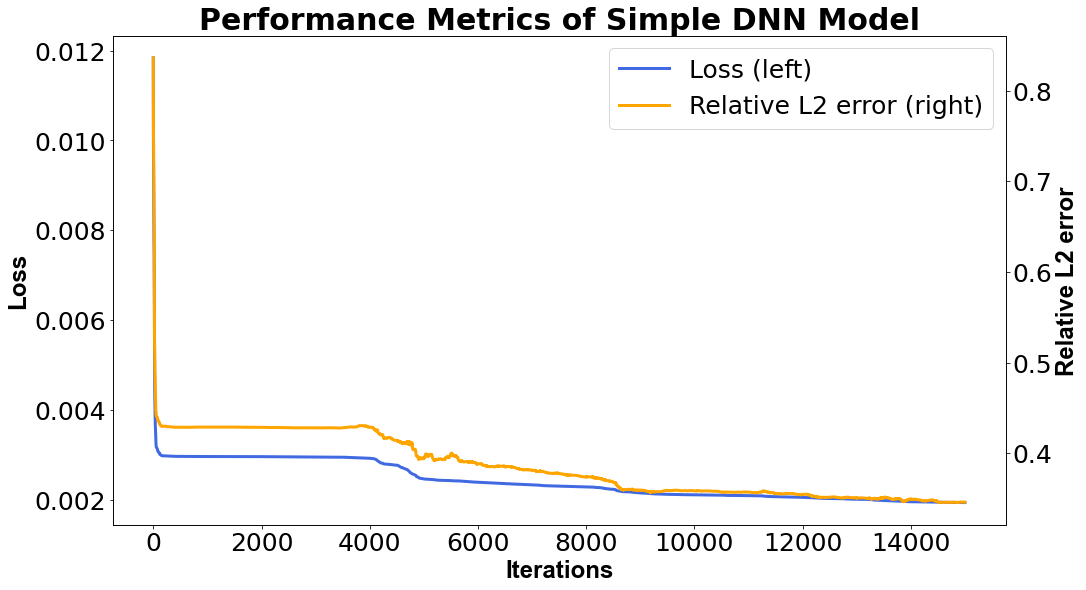

In [24]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.10539047240166334
MSE =  0.779108763509953
RMSE =  0.8826713791156666
L2 relative error = 7.405416560035021
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

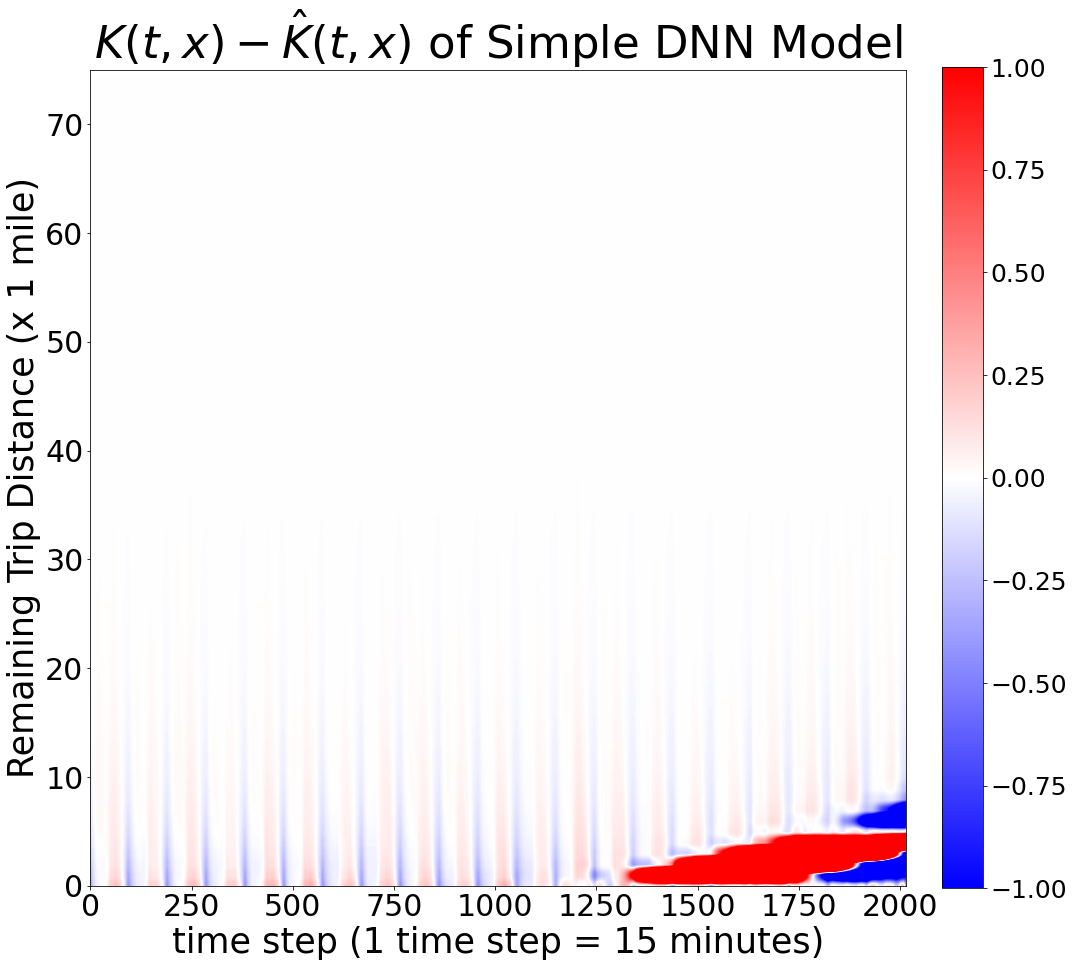

In [23]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

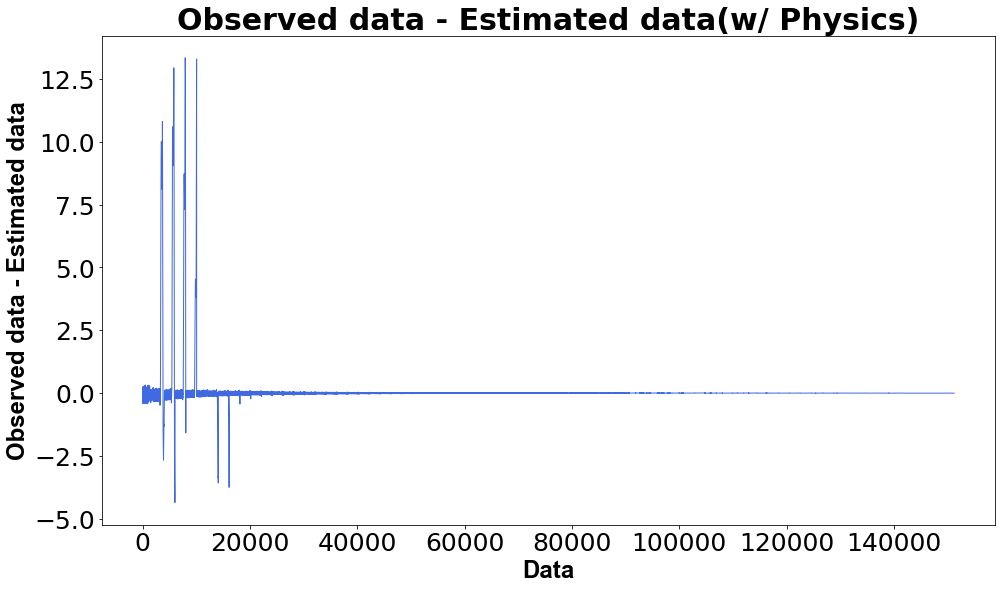

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)